# Inverted Repeats

# Exploratory Data Analysis


<span style="font-size:18.0pt;color:blue"> 
    
- IRP Count vs. Kmer Length <br>
- Density by taxonomy <br>
- correlation between GC content in arms and IR length <br>
- Are there dense hotspots of IRPs in each genome? <br>
- Are there taxonomic biases?- IRP Count vs. Kmer Length <br>
- Density by taxonomy <br>
- correlation between GC content in arms and IR length <br>
- Are there dense hotspots of IRPs in each genome? <br>
- Are there taxonomic biases? <br>
    
</span>

In [21]:
# data science
from scipy.stats import norm
import numpy as np
import sqlite3 as sql
import pandas as pd

# utilities
from dotenv import load_dotenv
import os
from pathlib import Path
from termcolor import colored
from tqdm import tqdm
import gzip
import math

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
import upsetplot
from upsetplot import UpSet
from upsetplot import plot
from wordcloud import WordCloud

In [22]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                 'Viruses': '#6bb5c7',
                 'Eukaryota': '#e69c3c',
                 'Archaea': '#b2b2ff',
                 'Bacteria': '#a3c4a3'
            }

kingdom_color_palette = {
                         "Viruses": "#6bb5c7",
                         "Bacteria": "#0fbf2d",
                         "Archaea": "#b2b2ff",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                         "Eubacteria": "#0fbf2d",
                         "Animalia": "#9bba2d",
                         "Protista": "#c78f5b",
                         "Archaeabacteria": "#7b7bed",
                } 

#### UTILIZING SEABORN 0.12.2

Adding any new graph to this notebook, make sure to use the following constants:

- xaxis, yaxis labelsize:
- xticks, yticks labelsize:
- legend props labelsize:
- legend title labelsize:

#### LOAD ENVIRONMENT

In [23]:
path = Path("/storage/group/izg5139/default/nicole/mindi/irp_out_no_eukaryotes/IR_extracted_accessions")

files = [f for f in path.glob("*.csv")]
len(files)

118072

In [24]:
empty_accessions = set()
all_accessions = set()
for f in tqdm(files, leave=True):
    df = pd.read_table(f)
    df = df[(df["armLength"] > 9) & (df["spacerLength"] < 9)]

    if df.shape[0] == 0:
        empty_accessions.add(f.name)

    all_accessions.add(f.name)

 19%|█▉        | 22366/118072 [00:49<03:33, 448.49it/s]

KeyboardInterrupt



In [ ]:
len(list(empty_accessions))

In [ ]:
len(list(all_accessions))

In [ ]:
load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")
IRP_DB = os.getenv("IRP_DB")
EMPTY_ASSEMBLIES_PATH = os.getenv("EMPTY_ASSEMBLIES")

assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB), "Invalid inverted repeats database."
assert os.path.isfile(EMPTY_ASSEMBLIES_PATH), "Invalid empty assemblies db."

In [ ]:
DATABASE

In [25]:
assembly_df = pd.read_table("/storage/group/izg5139/default/external/satellites/scripts/tandem_out/assembly_summary_newdb.txt.gz")
assembly_df

,#assembly_accession,genome_size,total_gene_count,protein_coding_gene_count,non_coding_gene_count,gc_percent,species_taxid,organism_name,phylum,kingdom,superkingdom
0,GCF_000762265.1,2449987,2445,2386,55,41.5,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
1,GCF_001458655.1,2494510,2462,2404,55,41.0,2162,Methanobacterium formicicum,Euryarchaeota,Archaeabacteria,Archaea
2,GCF_002813085.1,1805545,1782,1715,43,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
3,GCF_022846155.1,1791153,1738,1680,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
4,GCF_022846175.1,1791155,1739,1681,44,31.0,2173,Methanobrevibacter smithii,Euryarchaeota,Archaeabacteria,Archaea
...,...,...,...,...,...,...,...,...,...,...,...
118097,GCA_037114785.1,42928,na,na,na,35.0,3127874,Enterococcus phage vB_Efa_ZAT1,NaN,NaN,Viruses
118098,GCA_037114795.1,18740,na,na,na,37.5,3127946,Bacillus phage vB_Bsu_hmny1,NaN,NaN,Viruses
118099,GCA_037114805.1,18762,na,na,na,37.5,3127947,Bacillus phage vB_Bsu_hmny2,NaN,NaN,Viruses
118100,GCA_037114815.1,43533,na,na,na,43.5,3127948,Vibrio phage Va-ZX-1,NaN,NaN,Viruses


In [26]:
assembly_df.sample(10)

,#assembly_accession,genome_size,total_gene_count,protein_coding_gene_count,non_coding_gene_count,gc_percent,species_taxid,organism_name,phylum,kingdom,superkingdom
41239,GCF_000883535.1,65764,94,93,0,55.0,2006179,Pseudomonas phage PB1,Uroviricota,Heunggongvirae,Viruses
112951,GCA_031313365.1,9159,na,na,na,36.5,2933664,Bactrocera dorsalis cripavirus isolate Bo,Pisuviricota,Orthornavirae,Viruses
106782,GCA_003620355.1,2526,na,na,na,45.5,2748378,Cressdnaviricota sp.,Cressdnaviricota,Shotokuvirae,Viruses
107874,GCA_016836355.1,260727,na,na,na,27.0,2785444,Staphylococcus phage vB_StaM_SA1,Uroviricota,Heunggongvirae,Viruses
12495,GCF_030533645.1,2824934,2793,2623,82,33.0,1280,Staphylococcus aureus,Bacillota,Eubacteria,Bacteria
53704,GCA_034811165.1,1677156,1591,1477,46,39.0,210,Helicobacter pylori,Campylobacterota,Eubacteria,Bacteria
22060,GCF_013466605.1,6953033,6417,6195,88,62.5,587753,Pseudomonas chlororaphis subsp. aurantiaca,Pseudomonadota,Eubacteria,Bacteria
49859,GCF_006384355.1,43233,83,83,0,56.5,2956096,Aeromonas phage 2_D05,Uroviricota,Heunggongvirae,Viruses
47642,GCF_002627665.1,229929,402,402,0,38.5,2843652,Aeromonas phage AS-zj,Uroviricota,Heunggongvirae,Viruses
10769,GCF_022964995.1,2675016,2676,2504,82,41.0,728,Avibacterium paragallinarum,Pseudomonadota,Eubacteria,Bacteria


In [27]:
irp_df = pd.read_parquet(IRP_DB)
irp_df = irp_df[(irp_df["spacerLength"] < 9) & (irp_df["armLength"] > 9)]
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession
index,,,,,,,,,,,,,,,
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,2,0,4,4A/0C/2G/4T,GCA_000007325.1
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,0,0,6,4A/0C/0G/6T,GCA_000007325.1
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,0,3,5,3A/3C/0G/5T,GCA_000007325.1
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,0,0,3,7A/0C/0G/3T,GCA_000007325.1
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,1,3,4,3A/3C/1G/4T,GCA_000007325.1


In [28]:
extract_id = lambda accession: '_'.join(Path(accession).name.split("_")[:2])

In [29]:
empty_accessions_df = pd.DataFrame(empty_accessions, columns=["#assembly_accession"])
empty_accessions_df["#assembly_accession"] = empty_accessions_df["#assembly_accession"].apply(extract_id)
empty_accessions_df

,#assembly_accession
0,GCA_003927835.1
1,GCA_003087435.1
2,GCA_003097955.1
3,GCA_003085315.1
4,GCA_003616935.1
...,...
11657,GCA_003715205.1
11658,GCA_003654505.1
11659,GCA_004046435.1
11660,GCA_003109605.1


In [30]:
empty_accessions_df.shape[0] + irp_df["#assembly_accession"].nunique()

96584

In [31]:
irp_df = irp_df[irp_df['spacerLength'] < 9].reset_index(drop=True)
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,arm_g,arm_c,arm_t,composition,#assembly_accession
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,2,0,4,4A/0C/2G/4T,GCA_000007325.1
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,0,0,6,4A/0C/0G/6T,GCA_000007325.1
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,0,3,5,3A/3C/0G/5T,GCA_000007325.1
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,0,0,3,7A/0C/0G/3T,GCA_000007325.1
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,1,3,4,3A/3C/1G/4T,GCA_000007325.1


In [32]:
irp_df = irp_df.merge(
                      assembly_df[["#assembly_accession", "gc_percent", "organism_name", "phylum", "kingdom", "superkingdom", "genome_size"]], 
                      on="#assembly_accession"
                    )
irp_df

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,arm_c,arm_t,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,0,4,4A/0C/2G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,0,6,4A/0C/0G/6T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3,5,3A/3C/0G/5T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,0,3,7A/0C/0G/3T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3,4,3A/3C/1G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589127,NZ_OY986433.1,2998346,2998371,cactgctgctgg,a,cactgctgctggaccagcagcagtg,12,1,25,1,...,4,3,1A/4C/4G/3T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589128,NZ_OY986433.1,3028360,3028383,ttgcgggtggc,t,ttgcgggtggctgccacccgcaa,11,1,23,0,...,2,3,0A/2C/6G/3T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589129,NZ_OY986433.1,3046200,3046226,cggggaggtg,acccac,cggggaggtgacccaccacctccccg,10,6,26,1,...,1,1,1A/1C/7G/1T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273
29589130,NZ_OY986433.1,3053628,3053648,gtcacccagg,.,gtcacccaggcctgggtgac,10,0,20,2,...,4,1,2A/4C/3G/1T,GCF_963920505.1,66.0,Synechococcus sp. CBW1107,Cyanobacteriota,Eubacteria,Bacteria,3085273


In [33]:
irp_df.loc[:, "gc_content"] = irp_df["arm_g"] + irp_df["arm_c"]
irp_df.loc[:, "at_content"] = irp_df["arm_a"] + irp_df["arm_t"]

In [34]:
irp_df.shape

(29589132, 23)

In [35]:
irp_df.drop_duplicates().to_parquet("/storage/group/izg5139/default/external/satellites/scripts/enrichment/inverted_repeats/tree_of_life_inverted_repeats.parquet.snappy", compression="snappy")

In [36]:
assemblies = set(irp_df['#assembly_accession'])
len(assemblies)

84922

In [13]:
import json
with open("valid_assemblies.txt", "w") as f:
    for assembly in assemblies:
        f.write(assembly + "\n")

# Most common IRs per phylum

In [14]:
counts = irp_df.groupby(["phylum", "sequenceOfArm"], as_index=False)\
                .agg(totalCounts=("armLength", "count"))\
                .sort_values(by=['totalCounts'], ascending=False)
counts

,phylum,sequenceOfArm,totalCounts
3869355,Streptophyta,atatatatat,39236
2285633,Chordata,tagcattagg,36811
4003769,Streptophyta,tatatatata,35172
3192030,Pseudomonadota,cagcccgcat,34676
3869356,Streptophyta,atatatatata,34069
...,...,...,...
1690250,Bacteroidota,gttagtcccgatactttt,1
1690252,Bacteroidota,gttagttagtcgaaa,1
1690253,Bacteroidota,gttagttcgg,1
1690254,Bacteroidota,gttagttctataaaatc,1


In [19]:
counts[(counts['phylum'] == 'Nucleocytoviricota') & (counts['sequenceOfArm'].str.startswith("ataattatac"))].head(40)

,phylum,sequenceOfArm,totalCounts
2706390,Nucleocytoviricota,ataattatacta,3041


In [13]:
counts[counts['phylum'].str.startswith("Nucleo")]

,phylum,sequenceOfArm,totalCounts
2712396,Nucleocytoviricota,ttctgatatt,3247


# General Statistics about the IR

In [12]:
irp_df[["#assembly_accession", "superkingdom"]].drop_duplicates(subset=['#assembly_accession']).superkingdom.value_counts()

superkingdom
Bacteria     49196
Viruses      34583
Archaea        687
Eukaryota      456
Name: count, dtype: int64

In [13]:
irp_df.duplicated().sum()

0

In [29]:
tree_of_life = assembly_df[["#assembly_accession", "phylum", "kingdom", "superkingdom", "genome_size"]]

In [30]:
empty_accessions_df = empty_accessions_df.merge(tree_of_life, on="#assembly_accession", how="left")
empty_accessions_df

,#assembly_accession,phylum,kingdom,superkingdom,genome_size
0,GCA_022874065.1,Cressdnaviricota,Shotokuvirae,Viruses,1657
1,GCA_006441105.1,Preplasmiviricota,Bamfordvirae,Viruses,35371
2,GCA_014824525.1,Uroviricota,Heunggongvirae,Viruses,71854
3,GCF_000846785.1,Cressdnaviricota,Shotokuvirae,Viruses,1952
4,GCA_004036195.1,Cressdnaviricota,Shotokuvirae,Viruses,1995
...,...,...,...,...,...
33138,GCA_004056615.1,Cressdnaviricota,Shotokuvirae,Viruses,1767
33139,GCA_031137045.1,Pisuviricota,Orthornavirae,Viruses,7559
33140,GCF_018589485.1,Artverviricota,Pararnavirae,Viruses,8203
33141,GCF_001923315.1,NaN,Unclassified Viruses,Viruses,2654


In [179]:
empty_assemblies = pd.DataFrame(empty_assemblies, columns=["#assembly_accession"])
# empty_assemblies.loc[:, '#assembly_accession'] = empty_assemblies['#assembly_accession'].apply(lambda y: '_'.join(y.split('/')[-1].split('_')[:2]))
empty_assemblies = empty_assemblies.merge(tree_of_life, on="#assembly_accession", how="left")
empty_assemblies

,#assembly_accession,phylum,kingdom,superkingdom,genome_size
0,GCA_000838045.1,NaN,Unclassified Viruses,Viruses,14957
1,GCA_000842325.1,NaN,Unclassified Viruses,Viruses,1363
2,GCA_000848585.1,Negarnaviricota,Orthornavirae,Viruses,16236
3,GCA_000848765.1,Cossaviricota,Shotokuvirae,Viruses,5176
4,GCA_000851645.1,Kitrinoviricota,Orthornavirae,Viruses,4536
...,...,...,...,...,...
33114,GCF_900500615.1,Negarnaviricota,Orthornavirae,Viruses,15378
33115,GCF_900604365.1,Uroviricota,Heunggongvirae,Viruses,58916
33116,GCF_900692495.1,Pisuviricota,Orthornavirae,Viruses,7557
33117,GCF_902006465.1,Uroviricota,Heunggongvirae,Viruses,46703


In [223]:
irp_df["#assembly_accession"].nunique()

84922

In [222]:
empty_accessions_df.shape

(33143, 5)

In [224]:
33143 + 84922

118065

In [38]:
empty_assemblies = pd.read_csv(EMPTY_ASSEMBLIES_PATH, header=None, names=['#assembly_accession'])
empty_assemblies.loc[:, '#assembly_accession'] = empty_assemblies['#assembly_accession'].apply(lambda y: '_'.join(y.split('/')[-1].split('_')[:2]))
empty_assemblies = empty_assemblies.merge(tree_of_life, on="#assembly_accession", how="left")
empty_assemblies

,#assembly_accession,phylum,kingdom,superkingdom,genome_size
0,GCA_000838045.1,NaN,Unclassified Viruses,Viruses,14957
1,GCA_000842325.1,NaN,Unclassified Viruses,Viruses,1363
2,GCA_000848585.1,Negarnaviricota,Orthornavirae,Viruses,16236
3,GCA_000848765.1,Cossaviricota,Shotokuvirae,Viruses,5176
4,GCA_000851645.1,Kitrinoviricota,Orthornavirae,Viruses,4536
...,...,...,...,...,...
33114,GCF_900500615.1,Negarnaviricota,Orthornavirae,Viruses,15378
33115,GCF_900604365.1,Uroviricota,Heunggongvirae,Viruses,58916
33116,GCF_900692495.1,Pisuviricota,Orthornavirae,Viruses,7557
33117,GCF_902006465.1,Uroviricota,Heunggongvirae,Viruses,46703


In [39]:
total_unique_sequences = irp_df.sequenceOfArm.unique()
total_unique_sequences

array(['gtaaaagttt', 'ttaatatatt', 'cttctaatact', ..., 'cactgctgctgg',
       'ttgcgggtggc', 'cagtcttgctcctcccc'], dtype=object)

In [17]:
total_sequences = irp_df.shape[0]
total_sequences

29589132

In [18]:
total_species = irp_df['#assembly_accession'].nunique() + empty_assemblies.shape[0]
total_species

118041

In [225]:
total_empty = empty_assemblies.shape
total_empty

(33119, 5)

In [226]:
34607 + 33118

67725

In [228]:
empty_accessions_df.superkingdom.value_counts()

superkingdom
Viruses     33142
Bacteria        1
Name: count, dtype: int64

In [185]:
total_non_empty = irp_df['#assembly_accession'].nunique()
total_non_empty

84922

In [24]:
irp_df.loc[:, "gc_content"] = irp_df["sequenceOfArm"].apply(lambda seq: (seq.count("g") + seq.count("c"))/len(seq))

## Total IR Variation

# Total IR Coverage

In [22]:
irp_df.shape

(29589132, 23)

In [119]:
!ls /storage/group/izg5139/default/nicole/mindi/irp_out_no_eukaryotes

IR_completed					 irp_temp
IR_database_07_15_2024.brand_new.parquet.snappy  merged_accessions
IR_database_07_15_2024.new.parquet.snappy	 merged_old
IR_extracted_accessions				 schedule_100.json
inverted_repeats_db.parquet.snappy


In [24]:
df_merged = pd.read_parquet("/storage/group/izg5139/default/nicole/mindi/irp_out_no_eukaryotes/IR_database_07_15_2024.brand_new.parquet.snappy")
df_merged.loc[:, "sequenceLength"] = df_merged["end"] - df_merged["start"]
df_merged

,#assembly_accession,seqID,start,end,totalIR,sequenceLength
index,,,,,,
0,GCA_000007325.1,AE009951.2,17161,17183,1,22
1,GCA_000007325.1,AE009951.2,26386,26407,1,21
2,GCA_000007325.1,AE009951.2,47710,47740,1,30
3,GCA_000007325.1,AE009951.2,65000,65024,1,24
4,GCA_000007325.1,AE009951.2,76290,76316,1,26
...,...,...,...,...,...,...
191,GCF_963920505.1,NZ_OY986433.1,2998346,2998371,1,25
192,GCF_963920505.1,NZ_OY986433.1,3028360,3028383,1,23
193,GCF_963920505.1,NZ_OY986433.1,3046200,3046226,1,26


In [25]:
df_merged = df_merged.merge(assembly_df[["#assembly_accession", "phylum", "kingdom", "superkingdom", "organism_name", "genome_size"]],  
                            on="#assembly_accession",
                           how="left"
                           )
df_merged

,#assembly_accession,seqID,start,end,totalIR,sequenceLength,phylum,kingdom,superkingdom,organism_name,genome_size
0,GCA_000007325.1,AE009951.2,17161,17183,1,22,Fusobacteriota,Eubacteria,Bacteria,Fusobacterium nucleatum subsp. nucleatum ATCC ...,2174500
1,GCA_000007325.1,AE009951.2,26386,26407,1,21,Fusobacteriota,Eubacteria,Bacteria,Fusobacterium nucleatum subsp. nucleatum ATCC ...,2174500
2,GCA_000007325.1,AE009951.2,47710,47740,1,30,Fusobacteriota,Eubacteria,Bacteria,Fusobacterium nucleatum subsp. nucleatum ATCC ...,2174500
3,GCA_000007325.1,AE009951.2,65000,65024,1,24,Fusobacteriota,Eubacteria,Bacteria,Fusobacterium nucleatum subsp. nucleatum ATCC ...,2174500
4,GCA_000007325.1,AE009951.2,76290,76316,1,26,Fusobacteriota,Eubacteria,Bacteria,Fusobacterium nucleatum subsp. nucleatum ATCC ...,2174500
...,...,...,...,...,...,...,...,...,...,...,...
28765683,GCF_963920505.1,NZ_OY986433.1,2998346,2998371,1,25,Cyanobacteriota,Eubacteria,Bacteria,Synechococcus sp. CBW1107,3085273
28765684,GCF_963920505.1,NZ_OY986433.1,3028360,3028383,1,23,Cyanobacteriota,Eubacteria,Bacteria,Synechococcus sp. CBW1107,3085273
28765685,GCF_963920505.1,NZ_OY986433.1,3046200,3046226,1,26,Cyanobacteriota,Eubacteria,Bacteria,Synechococcus sp. CBW1107,3085273
28765686,GCF_963920505.1,NZ_OY986433.1,3053628,3053648,1,20,Cyanobacteriota,Eubacteria,Bacteria,Synechococcus sp. CBW1107,3085273


In [100]:
irp_df.groupby("kingdom").agg({"sequenceLength": "sum", "armLength": "count"})

,sequenceLength,armLength
kingdom,,
Animalia,110295853,3286270
Archaeabacteria,2430463,94483
Bamfordvirae,1803228,62690
Eubacteria,652083869,23008247
Fungi,9809440,381993
Helvetiavirae,243,9
Heunggongvirae,2695702,99820
Loebvirae,6329,235
Orthornavirae,178270,6873


In [99]:
df_merged.groupby("kingdom").agg({"sequenceLength": "sum", "totalIR": "sum"})

,sequenceLength,totalIR
kingdom,,
Animalia,95243746,3286270
Archaeabacteria,2422484,94483
Bamfordvirae,1735285,62690
Eubacteria,651207969,23008247
Fungi,9496341,381993
Helvetiavirae,243,9
Heunggongvirae,2684410,99820
Loebvirae,6329,235
Orthornavirae,177913,6873


In [31]:
def add_empty_assemblies(df):
    global empty_accessions_df
    return pd.concat([
                      df, 
                      empty_accessions_df.set_index("#assembly_accession")[["superkingdom", "genome_size"]]
                     ], 
                    axis=0
            )

In [32]:
irp_accessions_merged = df_merged.groupby("#assembly_accession")\
                                    .agg({
                                                          "sequenceLength": "sum",
                                                          "superkingdom": "first",
                                                          "genome_size": "first",
                                                          "organism_name": "first",
                                       })\
                                    .assign(coverage=lambda ds: (1e6 * ds['sequenceLength'].div(ds['genome_size']) ))
                                    #.drop(columns=['length'])

irp_accessions_merged = add_empty_assemblies(irp_accessions_merged)
irp_accessions_merged.loc[:, "coverage"] = irp_accessions_merged['coverage'].replace(np.nan, 0.0)
irp_accessions_merged = irp_accessions_merged.sort_values(by=['coverage'], ascending=False)
irp_accessions_merged

,sequenceLength,superkingdom,genome_size,organism_name,coverage
#assembly_accession,,,,,
GCA_031202825.1,396.0,Viruses,2196,Kummerowia striata partitivirus,180327.868852
GCA_031087385.1,81.0,Viruses,497,Pea necrotic yellow dwarf satellite DNA-X,162977.867203
GCA_004056055.1,296.0,Viruses,2001,Beak and feather disease virus,147926.036982
GCF_000873345.1,136.0,Viruses,1356,Tomato yellow leaf curl Vietnam betasatellite,100294.985251
GCA_031085915.1,136.0,Viruses,1357,Tomato leaf curl Vietnam virus satellite DNA b...,100221.075903
...,...,...,...,...,...
GCA_030347935.1,NaN,Viruses,39484,NaN,0.000000
GCA_902995075.1,NaN,Viruses,14548,NaN,0.000000
GCA_004772495.1,NaN,Viruses,13181,NaN,0.000000


In [34]:
irp_accessions_t = irp_accessions["coverage"].to_dict()
irp_accessions_l = irp_accessions["sequenceLength"].to_dict()

In [35]:
irp_accessions_merged.loc[:, "unmerged_cov"] = irp_accessions_merged.index.map(lambda x: irp_accessions_t[x])
irp_accessions_merged.loc[:, "Slength"] = irp_accessions_merged.index.map(lambda x: irp_accessions_l[x])
irp_accessions_merged.head()

,sequenceLength,superkingdom,genome_size,organism_name,coverage,unmerged_cov,Slength
#assembly_accession,,,,,,,
GCA_031202825.1,396.0,Viruses,2196,Kummerowia striata partitivirus,180327.868852,180327.868852,396.0
GCA_031087385.1,81.0,Viruses,497,Pea necrotic yellow dwarf satellite DNA-X,162977.867203,162977.867203,81.0
GCA_004056055.1,296.0,Viruses,2001,Beak and feather disease virus,147926.036982,147926.036982,296.0
GCF_000873345.1,136.0,Viruses,1356,Tomato yellow leaf curl Vietnam betasatellite,100294.985251,100294.985251,136.0
GCA_031085915.1,136.0,Viruses,1357,Tomato leaf curl Vietnam virus satellite DNA b...,100221.075903,100221.075903,136.0


In [36]:
irp_accessions_merged.query("unmerged_cov < coverage")

,sequenceLength,superkingdom,genome_size,organism_name,coverage,unmerged_cov,Slength
#assembly_accession,,,,,,,


In [33]:
irp_accessions = irp_df.groupby("#assembly_accession")\
                                    .agg({
                                                          "sequenceLength": "sum",
                                                          "superkingdom": "first",
                                                          "genome_size": "first",
                                                          "organism_name": "first",
                                       })\
                                    .assign(coverage=lambda ds: (1e6 * ds['sequenceLength'].div(ds['genome_size']) ))
                                    #.drop(columns=['sequenceLength'])

irp_accessions = add_empty_assemblies(irp_accessions)
irp_accessions.loc[:, "coverage"] = irp_accessions['coverage'].replace(np.nan, 0.0)
irp_accessions = irp_accessions.sort_values(by=['coverage'], ascending=False)
irp_accessions

,sequenceLength,superkingdom,genome_size,organism_name,coverage
#assembly_accession,,,,,
GCA_031202825.1,396.0,Viruses,2196,Kummerowia striata partitivirus,180327.868852
GCA_031087385.1,81.0,Viruses,497,Pea necrotic yellow dwarf satellite DNA-X,162977.867203
GCA_004056055.1,296.0,Viruses,2001,Beak and feather disease virus,147926.036982
GCF_000873345.1,136.0,Viruses,1356,Tomato yellow leaf curl Vietnam betasatellite,100294.985251
GCA_031085915.1,136.0,Viruses,1357,Tomato leaf curl Vietnam virus satellite DNA b...,100221.075903
...,...,...,...,...,...
GCA_003083635.1,NaN,Viruses,19499,NaN,0.000000
GCF_004787175.1,NaN,Viruses,2725,NaN,0.000000
GCA_003087455.1,NaN,Viruses,17723,NaN,0.000000


In [29]:
Path(DATABASE).mkdir(exist_ok=True)

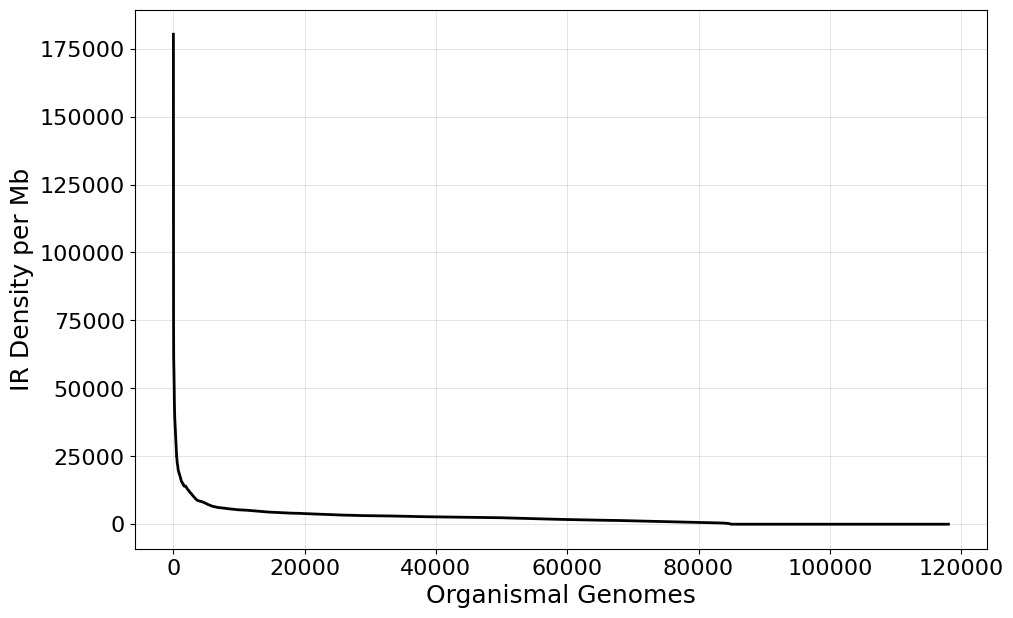

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))
irp_accessions_merged.reset_index().reset_index().plot(x='index', y='coverage', lw=2.0, color='black', ax=ax)
ax.set_xlabel("Organismal Genomes")
ax.set_ylabel("IR Density per Mb")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(handles=[], frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(lw=0.4, alpha=0.6)
fig.savefig(f"{DATABASE}/organismal_genomes_irp.png", format="png", bbox_inches='tight')
# plt.savefig(f"{DATABASE}/organismal_genomes_irp.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [31]:
grouped_by_arm_length = irp_df.groupby("armLength", as_index=False).agg(occurrences=("sequenceOfArm", "count"))\
                .sort_values(by=['armLength'], ascending=False)

grouped_by_arm_length.head()

,armLength,occurrences
608,117051,1
607,52115,1
606,47461,1
605,38727,2
604,38611,1


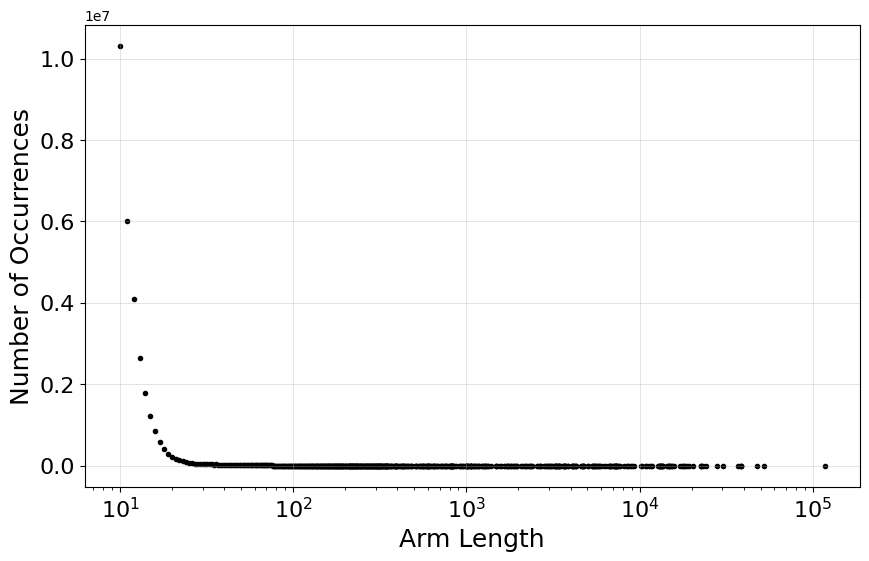

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.scatter(grouped_by_arm_length['armLength'], grouped_by_arm_length['occurrences'], s=9, color='black')
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Arm Length")
ax.set_ylabel("Number of Occurrences")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.legend(handles=[], frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(lw=0.4, alpha=0.6)
fig.savefig(f"{DATABASE}/arm_size_number_of_occurrences_irp.png", format="png", bbox_inches='tight')
plt.show()

# Longest Perfect IRs

In [183]:
grouped_genome_size.to_csv("grouped_genome_ir.csv.gz", compression="gzip", sep="\t", index=True, header=True)

In [32]:
irp_df.loc[:, "arm_gc_content"] = irp_df['sequenceOfArm'].apply(lambda arm: 100 * (arm.count("g") + arm.count("c")) / len(arm))

In [33]:
irp_df.query("armLength > 100")

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content,arm_gc_content
71197,CP008739.2,2309479,2310357,ggcttcgtcaacccgtcctcgttcaacttcttcgagtcggcgctga...,.,ggcttcgtcaacccgtcctcgttcaacttcttcgagtcggcgctga...,439,0,878,64,...,GCA_000473745.3,66.5,Pseudomonas aeruginosa VRFPA04,Pseudomonadota,Eubacteria,Bacteria,6818030,291,148,66.287016
71341,CP008739.2,3578020,3579236,cccccctggccatcgcccggctgtcgcgccggcgcctgctgtcctg...,.,cccccctggccatcgcccggctgtcgcgccggcgcctgctgtcctg...,608,0,1216,71,...,GCA_000473745.3,66.5,Pseudomonas aeruginosa VRFPA04,Pseudomonadota,Eubacteria,Bacteria,6818030,426,182,70.065789
75222,CP006736.1,254095,254341,tgaccatggcggtagacctgtgcagactgacaacgaggacaatgaa...,tcgtcctg,tgaccatggcggtagacctgtgcagactgacaacgaggacaatgaa...,119,8,246,41,...,GCA_000497505.1,51.0,Shigella dysenteriae 1617,Pseudomonadota,Eubacteria,Bacteria,4480198,55,64,46.218487
75628,HG425166.1,603854,606188,cagtaaaagtacatttagataggcttttttatagactgatcgtttg...,.,cagtaaaagtacatttagataggcttttttatagactgatcgtttg...,1167,0,2334,335,...,GCA_000499765.1,39.5,Methanobacterium sp. MB1,Euryarchaeota,Archaeabacteria,Archaea,2029766,352,815,30.162811
76326,CP006958.1,3656493,3656835,ggccgccggcgttgcgggcgccgcccggcgccgtgtggcaggcgac...,.,ggccgccggcgttgcgggcgccgcccggcgccgtgtggcaggcgac...,171,0,342,20,...,GCA_000508285.1,67.5,Achromobacter xylosoxidans NBRC 15126 = ATCC 2...,Pseudomonadota,Eubacteria,Bacteria,6683584,135,36,78.947368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29474072,NZ_LR883007.1,41861,42443,ttttttttgttttttccccttgaggacggtcagagttatctattga...,.,ttttttttgttttttccccttgaggacggtcagagttatctattga...,291,0,582,94,...,GCF_904831875.1,50.5,Escherichia coli,Pseudomonadota,Eubacteria,Bacteria,5403712,100,191,34.364261
29554400,NZ_OW967377.1,24030,26326,aatcctaccctactctcataaaaatatccttacagccattaaattt...,.,aatcctaccctactctcataaaaatatccttacagccattaaattt...,1148,0,2296,337,...,GCF_905322525.2,54.5,Klebsiella oxytoca,Pseudomonadota,Eubacteria,Bacteria,6391661,462,686,40.243902
29632814,NZ_OX341517.1,63023,63373,catgccgtgacattagtgacgggcacggtggcccagaacgtacggc...,gtctcgat,catgccgtgacattagtgacgggcacggtggcccagaacgtacggc...,171,8,350,35,...,GCF_946995915.1,63.5,Aminobacter niigataensis,Pseudomonadota,Eubacteria,Bacteria,5357197,109,62,63.742690
29632955,NZ_OX341517.1,1415663,1415969,gcgcccgcgcccagatcatcctccgcaggcaggtcgagcaattcct...,.,gcgcccgcgcccagatcatcctccgcaggcaggtcgagcaattcct...,153,0,306,27,...,GCF_946995915.1,63.5,Aminobacter niigataensis,Pseudomonadota,Eubacteria,Bacteria,5357197,106,47,69.281046


In [135]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'

In [176]:
!cat /storage/group/izg5139/default/ncbi_database/complete_accessions/2024-03-21_09-07-15/filtered_assemblies_2024_3_22.txt | grep -a 'GCF_900639495.1'

/storage/group/izg5139/default/ncbi_database/complete_accessions/2024-03-21_09-07-15/files/GCF_900639495.1_E7471_hybrid_assembly_genomic.fna.gz	bacteria	1


In [142]:
!pwd

/storage/home/nmc6088/irp_analysis


In [145]:
import pybedtools
pybedtools.set_tempdir("/storage/home/nmc6088/scratch")
from pybedtools import BedTool

In [177]:
gff_klebsiella = BedTool.from_dataframe(pd.read_table("/storage/group/izg5139/default/ncbi_database/complete_accessions/2024-03-21_09-07-15/files/GCF_900639495.1_E7471_hybrid_assembly_genomic.gff.gz", comment="#", header=None))
gff_klebsiella

<BedTool(/storage/home/nmc6088/scratch/pybedtools.9x2gc8y4.tmp)>

In [179]:
gff_df_kleb = gff_klebsiella.to_dataframe()
gff_df_kleb.loc[:, "start"] = gff_df_kleb["start"] - 1
gff_df_kleb = gff_df_kleb[gff_df_kleb["seqname"] == "NZ_LR135332.1"]
gff_df_kleb.loc[:, "type"] = gff_df_kleb["attributes"].apply(lambda x: x.split("gene_biotype=")[1].split(";")[0] if "gene_biotype=" in x else x)
gff_df_kleb

,seqname,source,feature,start,end,score,strand,frame,attributes,type
5780,NZ_LR135332.1,RefSeq,region,0,133389,.,+,.,ID=NZ_LR135332.1:1..133389;Dbxref=taxon:1352;N...,ID=NZ_LR135332.1:1..133389;Dbxref=taxon:1352;N...
5781,NZ_LR135332.1,RefSeq,gene,475,817,.,-,.,ID=gene-EQB74_RS14790;Name=EQB74_RS14790;gbkey...,protein_coding
5782,NZ_LR135332.1,Protein Homology,CDS,475,817,.,-,0,ID=cds-WP_002320747.1;Parent=gene-EQB74_RS1479...,ID=cds-WP_002320747.1;Parent=gene-EQB74_RS1479...
5783,NZ_LR135332.1,RefSeq,gene,806,1088,.,-,.,ID=gene-EQB74_RS14795;Name=EQB74_RS14795;gbkey...,protein_coding
5784,NZ_LR135332.1,Protein Homology,CDS,806,1088,.,-,0,ID=cds-WP_010733706.1;Parent=gene-EQB74_RS1479...,ID=cds-WP_010733706.1;Parent=gene-EQB74_RS1479...
...,...,...,...,...,...,...,...,...,...,...
6104,NZ_LR135332.1,Protein Homology,CDS,129792,130209,.,-,0,ID=cds-WP_127843754.1-2;Parent=gene-EQB74_RS15...,ID=cds-WP_127843754.1-2;Parent=gene-EQB74_RS15...
6105,NZ_LR135332.1,RefSeq,gene,130600,131848,.,+,.,ID=gene-EQB74_RS15605;Name=EQB74_RS15605;gbkey...,protein_coding
6106,NZ_LR135332.1,Protein Homology,CDS,130600,131848,.,+,0,ID=cds-WP_127843753.1-2;Parent=gene-EQB74_RS15...,ID=cds-WP_127843753.1-2;Parent=gene-EQB74_RS15...
6107,NZ_LR135332.1,RefSeq,gene,132117,133389,.,+,.,ID=gene-EQB74_RS15610;Name=EQB74_RS15610;end_r...,protein_coding


In [166]:
gff_df_kleb.query("start >= 1376976 & end <= 1613079")

,seqname,source,feature,start,end,score,strand,frame,attributes
2854,NZ_CP116903.1,RefSeq,gene,1377275,1377914,.,+,.,ID=gene-PO783_RS07010;Name=PO783_RS07010;gbkey...
2855,NZ_CP116903.1,Protein Homology,CDS,1377275,1377914,.,+,0,ID=cds-WP_004151988.1;Parent=gene-PO783_RS0701...
2856,NZ_CP116903.1,RefSeq,gene,1377904,1378885,.,+,.,ID=gene-PO783_RS07015;Name=PO783_RS07015;gbkey...
2857,NZ_CP116903.1,Protein Homology,CDS,1377904,1378885,.,+,0,ID=cds-WP_002913997.1;Parent=gene-PO783_RS0701...
2858,NZ_CP116903.1,RefSeq,gene,1379021,1380214,.,-,.,ID=gene-PO783_RS07020;Name=PO783_RS07020;gbkey...
...,...,...,...,...,...,...,...,...,...
3321,NZ_CP116903.1,RefSeq,pseudogene,1609809,1611774,.,+,.,ID=gene-PO783_RS08170;Name=PO783_RS08170;end_r...
3322,NZ_CP116903.1,Protein Homology,CDS,1609809,1611774,.,+,0,ID=cds-PO783_RS08170;Parent=gene-PO783_RS08170...
3323,NZ_CP116903.1,RefSeq,gene,1611841,1613034,.,+,.,ID=gene-PO783_RS08175;Name=PO783_RS08175;gbkey...
3324,NZ_CP116903.1,Protein Homology,CDS,1611841,1612118,.,+,0,ID=cds-WP_085955245.1-5;Parent=gene-PO783_RS08...


In [181]:
gff_df_kleb.query("start >= 29159 & end <= 133389")

,seqname,source,feature,start,end,score,strand,frame,attributes,type
5855,NZ_LR135332.1,RefSeq,gene,30700,31948,.,-,.,ID=gene-EQB74_RS14980;Name=EQB74_RS14980;gbkey...,protein_coding
5856,NZ_LR135332.1,Protein Homology,CDS,30700,31948,.,-,0,ID=cds-WP_127843753.1;Parent=gene-EQB74_RS1498...,ID=cds-WP_127843753.1;Parent=gene-EQB74_RS1498...
5857,NZ_LR135332.1,RefSeq,gene,32339,32756,.,+,.,ID=gene-EQB74_RS14985;Name=EQB74_RS14985;gbkey...,protein_coding
5858,NZ_LR135332.1,Protein Homology,CDS,32339,32756,.,+,0,ID=cds-WP_127843754.1;Parent=gene-EQB74_RS1498...,ID=cds-WP_127843754.1;Parent=gene-EQB74_RS1498...
5859,NZ_LR135332.1,RefSeq,gene,32772,33510,.,-,.,ID=gene-EQB74_RS14990;Name=EQB74_RS14990;gbkey...,protein_coding
...,...,...,...,...,...,...,...,...,...,...
6104,NZ_LR135332.1,Protein Homology,CDS,129792,130209,.,-,0,ID=cds-WP_127843754.1-2;Parent=gene-EQB74_RS15...,ID=cds-WP_127843754.1-2;Parent=gene-EQB74_RS15...
6105,NZ_LR135332.1,RefSeq,gene,130600,131848,.,+,.,ID=gene-EQB74_RS15605;Name=EQB74_RS15605;gbkey...,protein_coding
6106,NZ_LR135332.1,Protein Homology,CDS,130600,131848,.,+,0,ID=cds-WP_127843753.1-2;Parent=gene-EQB74_RS15...,ID=cds-WP_127843753.1-2;Parent=gene-EQB74_RS15...
6107,NZ_LR135332.1,RefSeq,gene,132117,133389,.,+,.,ID=gene-EQB74_RS15610;Name=EQB74_RS15610;end_r...,protein_coding


In [175]:
gff_df_kleb.query("start >= 1378976 & end <= 1613079").query("feature == 'gene'").iloc[0]['attributes']

'ID=gene-PO783_RS07020;Name=PO783_RS07020;gbkey=Gene;gene_biotype=protein_coding;locus_tag=PO783_RS07020;old_locus_tag=PO783_07020'

In [180]:
gff_df_kleb.query("start >=29159 & end <= 133389").query("feature == 'gene'")['type'].value_counts()

type
protein_coding    127
Name: count, dtype: int64

In [34]:
irp_df.query("sequenceLength > 10_000").sort_values(by=['sequenceLength'], ascending=False)

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content,arm_gc_content
24312240,NZ_CP116903.1,1378976,1613079,gtgttgtggtcaagtttttttggacacgccgatcagatggtagggt...,a,gtgttgtggtcaagtttttttggacacgccgatcagatggtagggt...,117051,1,234103,25073,...,GCF_028471925.1,57.0,Klebsiella pneumoniae,Pseudomonadota,Eubacteria,Bacteria,6084045,66082,50969,56.455733
29346741,NZ_LR135332.1,29159,133389,aaattcagcattagctaatggttttccatcttggtcaaccttttta...,.,aaattcagcattagctaatggttttccatcttggtcaaccttttta...,52115,0,104230,15774,...,GCF_900639495.1,37.5,Enterococcus faecium,Bacillota,Eubacteria,Bacteria,3273252,17399,34716,33.385781
29354188,NZ_LR135490.1,41297,136219,tgtgttcgtagcagtgtaactaaatttttgtccatcggtattaaca...,.,tgtgttcgtagcagtgtaactaaatttttgtccatcggtattaaca...,47461,0,94922,14607,...,GCF_900639715.1,37.5,Enterococcus faecium,Bacillota,Eubacteria,Bacteria,3440588,15574,31887,32.814311
8085485,LR698995.1,2089951,2167405,ccgcaccgtggcctcccacgcgctcaacatcttcggagaccattcc...,.,ccgcaccgtggcctcccacgcgctcaacatcttcggagaccattcc...,38727,0,77454,5967,...,GCA_902386885.1,68.0,Atopobiaceae bacterium,Actinomycetota,Eubacteria,Bacteria,2176737,26863,11864,69.365042
29072609,NZ_LT635455.1,2089951,2167405,ccgcaccgtggcctcccacgcgctcaacatcttcggagaccattcc...,.,ccgcaccgtggcctcccacgcgctcaacatcttcggagaccattcc...,38727,0,77454,5967,...,GCF_900119915.1,68.0,Olsenella timonensis,Actinomycetota,Eubacteria,Bacteria,2176737,26863,11864,69.365042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403744,CP088738.1,55778,66568,aaaaggaattgtccagctcagtagtgcaaccaacagcgcatctgaa...,.,aaaaggaattgtccagctcagtagtgcaaccaacagcgcatctgaa...,5395,0,10790,1571,...,GCA_021132795.1,50.5,Escherichia coli,Pseudomonadota,Eubacteria,Bacteria,5587699,2333,3062,43.243744
17651719,NZ_CP060865.1,0,10706,tttacacttatattatacacaccagtgtgtataataacaagagggt...,.,tttacacttatattatacacaccagtgtgtataataacaagagggt...,5353,0,10706,1822,...,GCF_014490015.1,37.5,Enterococcus faecium,Bacillota,Eubacteria,Bacteria,3317988,1673,3680,31.253503
19152598,NZ_CP072257.1,4860439,4871124,gaaatctgcaaagtctttgcagaactgtaacacgatctaacttctt...,gcaat,gaaatctgcaaagtctttgcagaactgtaacacgatctaacttctt...,5340,5,10685,1669,...,GCF_018292185.1,43.5,Bacteroides fragilis CL03T12C07,Bacteroidota,Eubacteria,Bacteria,5224217,1910,3430,35.767790
14887281,NZ_CP109969.1,2074040,2084144,gaaaggttcgaagttctttgtgcaggaagaaaacatcaacctcgca...,.,gaaaggttcgaagttctttgtgcaggaagaaaacatcaacctcgca...,5052,0,10104,1184,...,GCF_005144505.2,59.0,Agrobacterium salinitolerans,Pseudomonadota,Eubacteria,Bacteria,5705251,2581,2471,51.088678


In [92]:
irp_df.sort_values(by=['armLength'], 
                   ascending=False)\
                .query("armLength > 500")\
                                [[
                                    "#assembly_accession", 
                                    "organism_name", 
                                    "armLength", 
                                    "spacerLength", 
                                    "arm_gc_content", 
                                    "phylum", 
                                    "kingdom", 
                                    "superkingdom"
                                ]]\
            .to_csv(f"{DATABASE}/large_inverted_repeats_db.csv", index=False, mode="w")

# Correlation between long arms and AT-Content

In [37]:
from scipy.stats import pearsonr

In [226]:
data = {}

for domain in tqdm(domains, leave=True, position=0):
    chunk = irp_df.query(f"superkingdom == '{domain}'")
    data.update({domain: {}})
    for arm_length in tqdm(range(20, 210, 10), leave=True, position=0):
        chunk = chunk.query(f"armLength >= {arm_length}")
        r, p = pearsonr(chunk['armLength'], 1-chunk['gc_content'])
        data[domain].update({arm_length: (r, p)})

100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


## Relative TA-Content Spearman Correlation with Arm Length (Perfect Palindromes)

In [227]:
irp_df.loc[:, "gc_proportion"] = (irp_df["arm_g"] + irp_df["arm_c"]) / irp_df["sequenceLength"]
irp_df.loc[:, "ta_proportion"] = (irp_df["arm_t"] + irp_df["arm_a"]) / irp_df["sequenceLength"]

In [229]:
from scipy.stats import spearmanr

for domain in domains:
    chunk = irp_df[["gc_content", 
                    "spacerLength", 
                    "armLength", 
                    "superkingdom", 
                    "gc_proportion"
                   ]].query(f"superkingdom == '{domain}' & spacerLength == 0")

    
    chunk.loc[:, "ta_proportion"] = 100 * (1 - chunk["gc_proportion"])
    chunk.loc[:, "ta_content"] = 100 - chunk["gc_content"]
    
    chunk.loc[:, "relative_ta"] = chunk["ta_content"].div(chunk["ta_proportion"])
    r, p  = spearmanr(chunk['armLength'], chunk['relative_ta'])
    print("RELATIVE TA")
    print(domain, r, p)

RELATIVE TA
Archaea -0.03267411531032131 0.0001643973592836424
RELATIVE TA
Eukaryota -0.3443067741592025 0.0
RELATIVE TA
Bacteria -0.2629565770909876 0.0
RELATIVE TA
Viruses -0.1882947201299599 2.894670478468835e-237


### Eukaryota & Viruses TA-Content Correlation with Large Arm Lengths

In [76]:
irp_df[["arm_gc_content", "gc_proportion"]].head()

,arm_gc_content,gc_proportion
0,20.000000,0.090909
1,0.000000,0.000000
2,27.272727,0.100000
3,0.000000,0.000000
4,36.363636,0.153846


In [230]:
for domain in domains:
    chunk = irp_df[["gc_content", 
                    "sequenceOfArm", 
                    "spacerLength", 
                    "armLength", 
                    "kingdom", 
                    "superkingdom", 
                    "gc_proportion"
                   ]].query(f"superkingdom == '{domain}' & armLength < 21")
    
    chunk.loc[:, "gc_enrichment"] = chunk["gc_content"].div( 100 * chunk["gc_proportion"] )
    chunk_arm = chunk.groupby("armLength", as_index=False).agg({"gc_enrichment": "median"})
    r, p  = spearmanr(chunk_arm['armLength'], chunk_arm['gc_enrichment'])
    print("ARM LENGTH")
    print(domain, r, p)

    chunk_spacer = chunk.groupby("spacerLength", as_index=False).agg({"gc_enrichment": "median"})
    r, p  = spearmanr(chunk_spacer['spacerLength'], chunk_spacer['gc_enrichment'])
    
    print("SPACER")
    print(domain, r, p)

ARM LENGTH
Archaea 1.0 0.0
SPACER
Archaea nan nan
ARM LENGTH
Eukaryota 1.0 0.0
SPACER
Eukaryota 0.999137982940017 1.268075620149659e-138
ARM LENGTH
Bacteria 1.0 0.0
SPACER
Bacteria 0.9988496950839576 2.0062030072972773e-132
ARM LENGTH
Viruses 0.990909090909091 3.762571807085399e-09
SPACER
Viruses nan nan


In [231]:
irp_df.superkingdom.value_counts()

superkingdom
Bacteria     23044180
Eukaryota     6441211
Viruses        196915
Archaea         94914
Name: count, dtype: int64

In [232]:
irp_df[['#assembly_accession', 'superkingdom']].drop_duplicates().superkingdom.value_counts()

superkingdom
Bacteria     49196
Viruses      34607
Archaea        687
Eukaryota      456
Name: count, dtype: int64

### Relative GC Content vs. Hairpin Arm Length

In [85]:
from scipy.stats import spearmanr

for domain in domains:
    chunk = irp_df[["arm_gc_content", 
                    "spacerLength", 
                    "armLength", 
                    "superkingdom", 
                    "ta_proportion"
                   ]].query(f"superkingdom == '{domain}'")
    
    chunk = chunk.groupby("armLength", as_index=False).agg({"ta_proportion": "median"})
    r, p  = spearmanr(chunk['armLength'], chunk['ta_proportion'])
    print(domain, r, p)

Archaea 0.442497328130209 0.018377495627240014
Eukaryota -0.7739977535660395 4.321602951891834e-62
Bacteria 0.1645163741837087 0.0002741562254083405
Viruses -0.5672736533867208 7.868196326580412e-12


# Venn & Upset: Unique IR Analysis

In [233]:
grouped_genome_size = irp_df.groupby("sequenceOfArm").agg(
                                                          total_arm=("armLength", "first"), 
                                                          total_gap=("spacerLength", "sum"),
                                                          gap_unique=("spacerLength", lambda ds: set(ds.tolist())),
                                                          total_counts=("kingdom", "count"),
                                                          superkingdom=("superkingdom", lambda ds: set(ds.tolist())),
                                    )\
                            .sort_values(by=['total_counts'], ascending=False)

grouped_genome_size

,total_arm,total_gap,gap_unique,total_counts,superkingdom
sequenceOfArm,,,,,
atatatatat,10,231233,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",87517,"{Viruses, Bacteria, Archaea, Eukaryota}"
tatatatata,10,168942,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",78873,"{Viruses, Bacteria, Archaea, Eukaryota}"
atatatatata,11,115457,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",70164,"{Viruses, Bacteria, Archaea, Eukaryota}"
tatatatatat,11,105734,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",62835,"{Viruses, Bacteria, Archaea, Eukaryota}"
atatatatatat,12,83066,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",55798,"{Viruses, Bacteria, Archaea, Eukaryota}"
...,...,...,...,...,...
aaggcggtcccaa,13,0,{0},0,{Viruses}
ataaagggggaat,13,4,{1},0,{Viruses}
tgatattaacattcaataagtgatca,26,2,{2},0,{Viruses}


In [234]:
grouped_genome_size = grouped_genome_size\
                        .sort_values(by=['total_counts'], ascending=False)\
                        .assign(armLength=lambda df: df.index.map(len))\
                        .assign(gap_diversity=lambda df: df['gap_unique'].apply(len))

grouped_genome_size

,total_arm,total_gap,gap_unique,total_counts,superkingdom,armLength,gap_diversity
sequenceOfArm,,,,,,,
atatatatat,10,231233,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",87517,"{Viruses, Bacteria, Archaea, Eukaryota}",10,101
tatatatata,10,168942,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",78873,"{Viruses, Bacteria, Archaea, Eukaryota}",10,101
atatatatata,11,115457,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",70164,"{Viruses, Bacteria, Archaea, Eukaryota}",11,100
tatatatatat,11,105734,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",62835,"{Viruses, Bacteria, Archaea, Eukaryota}",11,100
atatatatatat,12,83066,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",55798,"{Viruses, Bacteria, Archaea, Eukaryota}",12,100
...,...,...,...,...,...,...,...
ccctagtagcc,11,6,{6},0,{Viruses},11,1
gctaactctgg,11,4,{4},0,{Viruses},11,1
taagaccctca,11,6,{1},0,{Viruses},11,1


In [238]:
for domain in domains:
    grouped_genome_size.loc[:, domain] = grouped_genome_size['superkingdom'].apply(lambda y: domain in y).astype(int)
grouped_genome_size

,total_arm,total_gap,gap_unique,total_counts,superkingdom,armLength,gap_diversity,Archaea,Eukaryota,Bacteria,Viruses
sequenceOfArm,,,,,,,,,,,
atatatatat,10,231233,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",87517,"{Viruses, Bacteria, Archaea, Eukaryota}",10,101,1,1,1,1
tatatatata,10,168942,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",78873,"{Viruses, Bacteria, Archaea, Eukaryota}",10,101,1,1,1,1
atatatatata,11,115457,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",70164,"{Viruses, Bacteria, Archaea, Eukaryota}",11,100,1,1,1,1
tatatatatat,11,105734,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",62835,"{Viruses, Bacteria, Archaea, Eukaryota}",11,100,1,1,1,1
atatatatatat,12,83066,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",55798,"{Viruses, Bacteria, Archaea, Eukaryota}",12,100,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ccctagtagcc,11,6,{6},0,{Viruses},11,1,0,0,0,1
gctaactctgg,11,4,{4},0,{Viruses},11,1,0,0,0,1
taagaccctca,11,6,{1},0,{Viruses},11,1,0,0,0,1


In [239]:
upset_domains = grouped_genome_size.groupby(list(domains))\
                                    .agg({
                                          "armLength": "mean", 
                                          "gap_diversity": "mean",
                                          "total_arm": "count",
                                         }
                                    )\
                                    .rename(
                                            columns={
                                                "armLength": "Mean Arm Size", 
                                                "gap_diversity": "Spacer Diversity"
                                                }
                            )\
                            .sort_values(by=['total_arm'], ascending=False)\
                            .assign(intersection=lambda x: x['total_arm'].apply(lambda y: math.log(y+1, 10)))

    
upset_domains

Mean Arm Size  Spacer Diversity  \
Archaea Eukaryota Bacteria Viruses                                    
0       0         1        0            14.543312          1.215202   
        1         0        0            14.980122          1.208769   
                  1        0            10.465181          3.319698   
        0         0        1            14.716191          1.015039   
1       0         0        0            12.543553          1.019317   
                  1        0            10.406606          3.491446   
0       0         1        1            10.955420          3.091337   
        1         1        1            10.421934          6.259082   
1       1         1        0            10.238488          6.109484   
0       1         0        1            11.074776          2.927857   
1       1         0        0            10.476632          2.586424   
                  1        1            10.255643         12.205594   
        0         1        1            10.146993          5.407572   
                  0        1            10.536232          1.869565   
        1         0        1            10.410714          4.392857   

                                    total_arm  intersection  
Archaea Eukaryota Bacteria Viruses                           
0       0         1        0          2519433      6.401303  
        1         0        0           788811      5.896974  
                  1        0           188462      5.275226  
        0         0        1            26465      4.422688  
1       0         0        0            19413      4.288115  
                  1        0            14380      4.157789  
0       0         1        1            11485      4.060169  
        1         1        1             8781      3.943593  
1       1         1        0             7992      3.902710  
0       1         0        1             3798      3.579669  
1       1         0        0             2696      3.430881  
                  1        1             2038      3.309417  
        0         1        1              449      2.653213  
                  0        1               69      1.845098  
        1         0        1               56      1.755875

In [240]:
import warnings
warnings.filterwarnings('ignore') 

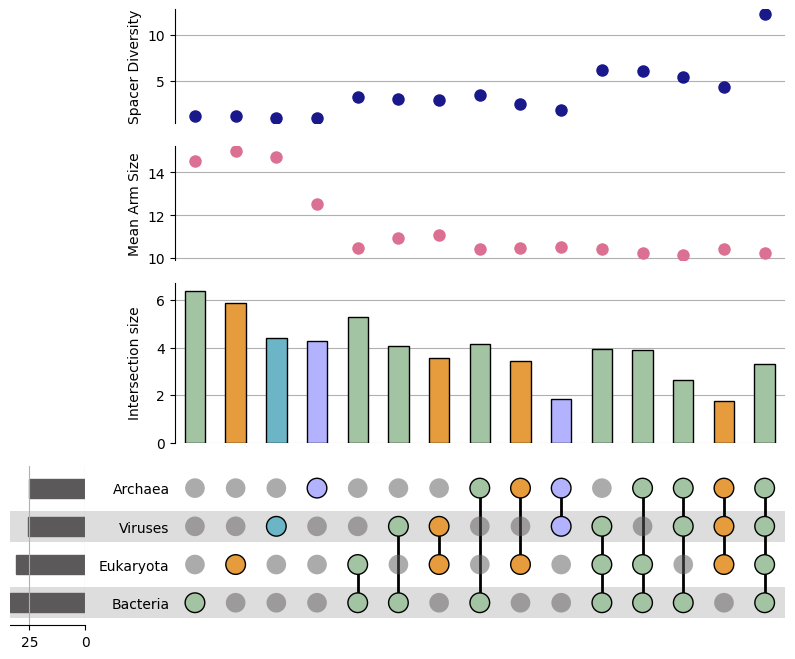

In [249]:
# UpSet plot it!

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
upset = UpSet(upset_domains,
              subset_size="sum", 
              facecolor='#5B5959', 
              sum_over="intersection", 
              intersection_plot_elements=4, 
              element_size=None,
              other_dots_color=0.5,
              shading_color=0.2,
             )

upset.style_subsets(present=["Bacteria"],
                    facecolor=domain_colors["Bacteria"],
                    edgecolor="black"
                    )
    
upset.style_subsets(present=["Eukaryota"],
                    absent=["Bacteria"],
                    facecolor=domain_colors["Eukaryota"],
                    edgecolor="black"
                    )
upset.style_subsets(present=["Archaea"],
                    absent=["Bacteria", "Eukaryota"],
                    facecolor=domain_colors["Archaea"],
                    edgecolor="black"
                    )
upset.style_subsets(present=["Viruses"],
                    absent=["Bacteria", "Eukaryota", "Archaea"],
                    facecolor=domain_colors["Viruses"],
                    edgecolor="black"
                    )


upset.add_catplot(value="Mean Arm Size", kind="strip", color="#DB7093", alpha=1.0, size=9)
upset.add_catplot(value="Spacer Diversity", kind="strip", color="navy", alpha=0.9, size=9)
upset.plot(fig=fig)
ax.axis("off")
ax.legend(handles=[], frameon=False)
plt.savefig(f"{DATABASE}/upset_intersections.png", format="png", bbox_inches='tight')
plt.show()

# Regression Analysis

In [38]:
def add_empty_assemblies(df):
    return pd.concat([
                    df, 
                    empty_accessions_df.set_index("#assembly_accession")[["genome_size", "phylum", "kingdom", "group", "superkingdom"]]
                ], 
            axis=0)

In [39]:
grouped_genome_size_or = irp_df.groupby("#assembly_accession")\
                                        .agg({
                                                "sequenceLength": "sum", 
                                                "genome_size": "first",
                                                "phylum": "first",
                                                "kingdom": "first",
                                                "superkingdom": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength'].div(df['genome_size'])) )\
                            .drop(columns=['sequenceLength'])

grouped_genome_size_or

,genome_size,phylum,kingdom,superkingdom,coverage
#assembly_accession,,,,,
GCA_000007325.1,2174500,Fusobacteriota,Eubacteria,Bacteria,3091.285353
GCA_000007385.1,4941439,Pseudomonadota,Eubacteria,Bacteria,2193.288230
GCA_000008005.1,5432652,Bacillota,Eubacteria,Bacteria,8288.953535
GCA_000008085.1,490885,Nanoarchaeota,Archaeabacteria,Archaea,843.374721
GCA_000008885.1,703004,Pseudomonadota,Eubacteria,Bacteria,9092.409147
...,...,...,...,...,...
GCF_963920465.1,2816659,Cyanobacteriota,Eubacteria,Bacteria,2040.360583
GCF_963920475.1,3210252,Cyanobacteriota,Eubacteria,Bacteria,2147.183461
GCF_963920485.1,2656680,Cyanobacteriota,Eubacteria,Bacteria,1245.539546


In [41]:
grouped_genome_size_or = pd.concat([grouped_genome_size_or, 
                                 empty_accessions_df.set_index("#assembly_accession")\
                                [["genome_size", "phylum", "kingdom", "superkingdom"]]
                                ], 
                        axis=0)
grouped_genome_size_or

,genome_size,phylum,kingdom,superkingdom,coverage
#assembly_accession,,,,,
GCA_000007325.1,2174500,Fusobacteriota,Eubacteria,Bacteria,3091.285353
GCA_000007385.1,4941439,Pseudomonadota,Eubacteria,Bacteria,2193.288230
GCA_000008005.1,5432652,Bacillota,Eubacteria,Bacteria,8288.953535
GCA_000008085.1,490885,Nanoarchaeota,Archaeabacteria,Archaea,843.374721
GCA_000008885.1,703004,Pseudomonadota,Eubacteria,Bacteria,9092.409147
...,...,...,...,...,...
GCA_004056615.1,1767,Cressdnaviricota,Shotokuvirae,Viruses,NaN
GCA_031137045.1,7559,Pisuviricota,Orthornavirae,Viruses,NaN
GCF_018589485.1,8203,Artverviricota,Pararnavirae,Viruses,NaN


In [42]:
grouped_genome_size = df_merged.groupby("#assembly_accession")\
                                        .agg({
                                                "sequenceLength": "sum", 
                                                "genome_size": "first",
                                                "phylum": "first",
                                                "kingdom": "first",
                                                "superkingdom": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength'].div(df['genome_size'])) )\
                            .drop(columns=['sequenceLength'])

grouped_genome_size

,genome_size,phylum,kingdom,superkingdom,coverage
#assembly_accession,,,,,
GCA_000007325.1,2174500,Fusobacteriota,Eubacteria,Bacteria,3088.066222
GCA_000007385.1,4941439,Pseudomonadota,Eubacteria,Bacteria,2185.395793
GCA_000008005.1,5432652,Bacillota,Eubacteria,Bacteria,8280.670288
GCA_000008085.1,490885,Nanoarchaeota,Archaeabacteria,Archaea,843.374721
GCA_000008885.1,703004,Pseudomonadota,Eubacteria,Bacteria,8864.814425
...,...,...,...,...,...
GCF_963920465.1,2816659,Cyanobacteriota,Eubacteria,Bacteria,2034.325064
GCF_963920475.1,3210252,Cyanobacteriota,Eubacteria,Bacteria,2146.871959
GCF_963920485.1,2656680,Cyanobacteriota,Eubacteria,Bacteria,1245.539546


In [43]:
grouped_genome_size = pd.concat([grouped_genome_size, 
                                 empty_accessions_df.set_index("#assembly_accession")\
                                [["genome_size", "phylum", "kingdom", "superkingdom"]]
                                ], 
                        axis=0)
grouped_genome_size

,genome_size,phylum,kingdom,superkingdom,coverage
#assembly_accession,,,,,
GCA_000007325.1,2174500,Fusobacteriota,Eubacteria,Bacteria,3088.066222
GCA_000007385.1,4941439,Pseudomonadota,Eubacteria,Bacteria,2185.395793
GCA_000008005.1,5432652,Bacillota,Eubacteria,Bacteria,8280.670288
GCA_000008085.1,490885,Nanoarchaeota,Archaeabacteria,Archaea,843.374721
GCA_000008885.1,703004,Pseudomonadota,Eubacteria,Bacteria,8864.814425
...,...,...,...,...,...
GCA_004056615.1,1767,Cressdnaviricota,Shotokuvirae,Viruses,NaN
GCA_031137045.1,7559,Pisuviricota,Orthornavirae,Viruses,NaN
GCF_018589485.1,8203,Artverviricota,Pararnavirae,Viruses,NaN


In [44]:
grouped_genome_size_or['coverage'] = grouped_genome_size_or['coverage'].replace(np.nan, 0.0)
grouped_genome_size['coverage'] = grouped_genome_size['coverage'].replace(np.nan, 0.0)

In [45]:
grouped_genome_size["coverage"].min(), grouped_genome_size["coverage"].max(), grouped_genome_size["coverage"].median()

(0.0, 180327.868852459, 1782.441863606056)

In [168]:
grouped_genome_size["coverage"].min(), grouped_genome_size["coverage"].max(), grouped_genome_size["coverage"].median()

(0.0, 180327.868852459, 931.9131431530416)

In [169]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'

Archaea 0.46390136548998534 5.879522592416705e-38


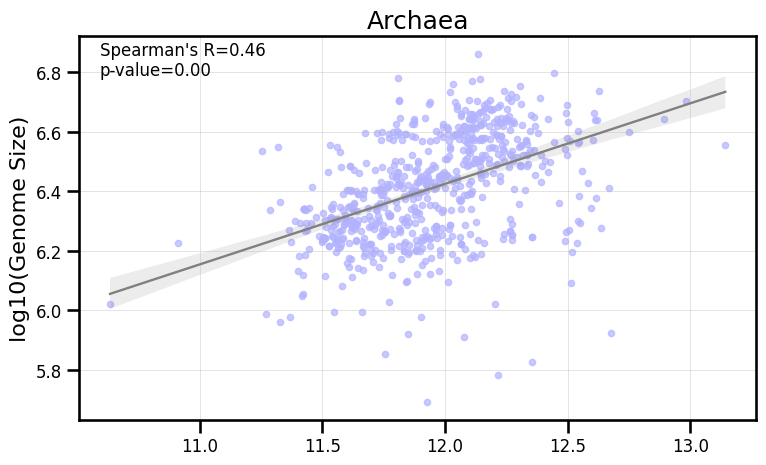

Eukaryota 0.4979927238528267 5.956398912145732e-30


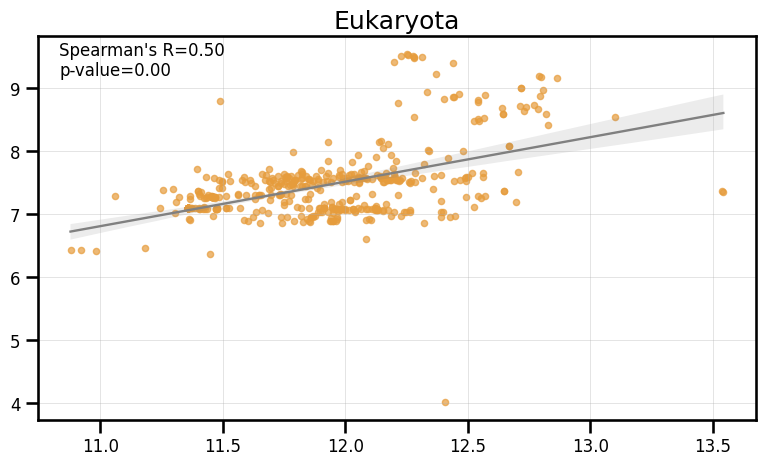

Bacteria 0.020367090169794877 6.246917759348545e-06


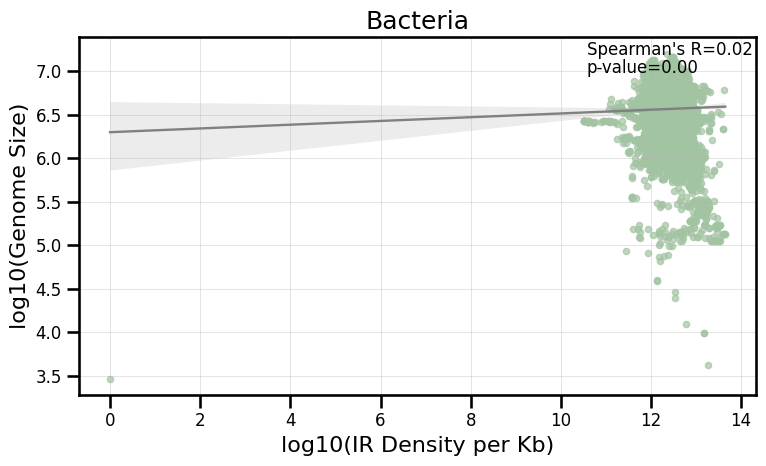

Viruses 0.4773226788755132 0.0


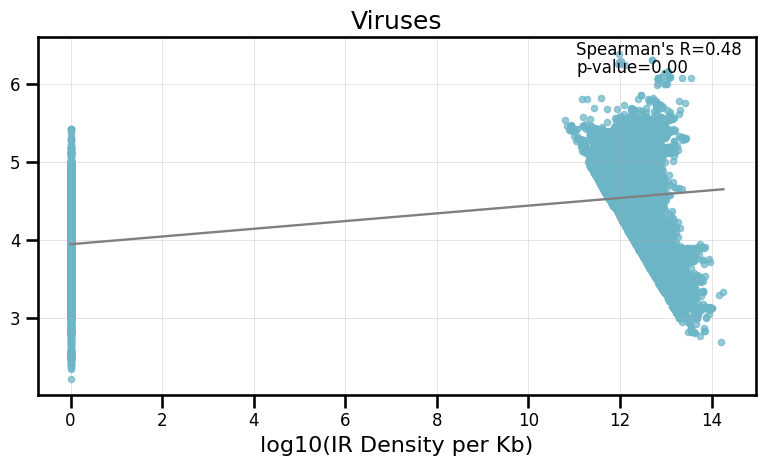

In [82]:
from scipy.stats import pearsonr

for domain in domains:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    grouped_slice = grouped_genome_size.query(f"superkingdom == '{domain}'")
    grouped_slice.loc[:, 'genome_size'] = grouped_slice['genome_size'].apply(lambda g: math.log(g+1, 10))
    grouped_slice.loc[:, "coverage"] = grouped_slice["coverage"].apply(lambda g: math.log(g*1e9+1, 10))
    r, p = pearsonr(grouped_slice['coverage'], grouped_slice['genome_size'])
    
    sns.regplot(data=grouped_slice, 
                color=domain_colors[domain], 
                x="coverage", 
                y="genome_size",  
                ci=95, 
                ax=ax,
                scatter_kws={
                             "color": domain_colors[domain], 
                             "alpha": 0.7, 
                             "s": 20
                            }, 
                line_kws={
                          "color": "gray", 
                          "lw": 1.7, 
                          "ls": "-"
                        }
               )

    print(domain, r, p)
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    if not (domain == "Viruses" or domain == "Eukaryota"):
        ax.set_ylabel("log10(Genome Size)")
    else:
        ax.set_ylabel("")
        
    if not (domain == "Archaea" or domain == "Eukaryota"):
        ax.set_xlabel("log10(IR Density per Kb)")
    else:
        ax.set_xlabel("")
        
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.set_title(domain)
    ax.title.set_size(18)
    # ax.set_xlim(xmin=-0.05, xmax=positive_group['coverage'].max() + 0.05)

    
    ax.tick_params(axis="both", which="major", labelsize=12)
    plt.tight_layout()
    if domain == 'Viruses' or domain == 'Bacteria':
        plt.text(.75, 0.95, 'Spearman\'s R={:.2f}'.format(r), fontsize=12, transform=ax.transAxes)
        plt.text(.75, 0.90, 'p-value={:.2f}'.format(p), fontsize=12, transform=ax.transAxes)  
    else:
        plt.text(.03, 0.95, 'Spearman\'s R={:.2f}'.format(r), fontsize=12, transform=ax.transAxes)
        plt.text(.03, 0.90, 'p-value={:.2f}'.format(p), fontsize=12, transform=ax.transAxes)
    
    # fig.savefig(f"{DATABASE}/ir_coverage_vs_genome_size_superkingdoms_{domain}.png", bbox_inches='tight')
    plt.show()

# IR Length vs. Genome Size

In [192]:
grouped_genome_size_ir = irp_df.groupby("#assembly_accession").agg(
                                                          total_arm_size=("armLength", lambda ds: ds.sum() * 2), 
                                                          total_gap_size=("spacerLength", "sum"),
                                                          genome_size=("genome_size", "first"),
                                                          total_ir=("spacerLength", "count"),
                                                          superkingdom=("superkingdom", "first"),
                                    )\
                            .assign(coverage=lambda df: 1e6 * (df['total_arm_size'] + df['total_gap_size']).div(df['genome_size']))

grouped_genome_size_ir = pd.concat([
                                grouped_genome_size_ir, 
                                empty_assemblies.set_index("#assembly_accession")
                                ], 
                            axis=0)
grouped_genome_size_ir["total_ir"] = grouped_genome_size_ir["total_ir"].replace(np.nan, 0.0)

grouped_genome_size_ir = grouped_genome_size_ir.assign(genome_size=lambda df: df['genome_size'].apply(lambda y: math.log(y+1, 10)))\
                                                .assign(total_ir=lambda df: df['total_ir'].apply(lambda y: math.log(y+1, 10)))

grouped_genome_size_ir = grouped_genome_size_ir.rename(columns={"superkingdom": "domain"})
grouped_genome_size_ir

,total_arm_size,total_gap_size,genome_size,total_ir,domain,coverage,phylum,kingdom
#assembly_accession,,,,,,,,
GCA_000007325.1,5710.0,1012.0,6.337360,2.389166,Bacteria,3091.285353,NaN,NaN
GCA_000007385.1,9336.0,1605.0,6.693854,2.599883,Bacteria,2214.132361,NaN,NaN
GCA_000008005.1,38674.0,6357.0,6.735012,3.151063,Bacteria,8288.953535,NaN,NaN
GCA_000008085.1,372.0,143.0,5.690981,1.278754,Archaea,1049.125559,NaN,NaN
GCA_000008885.1,5624.0,867.0,5.846958,2.401401,Bacteria,9233.233381,NaN,NaN
...,...,...,...,...,...,...,...,...
GCF_900500615.1,NaN,NaN,4.186928,0.000000,Viruses,NaN,Negarnaviricota,Orthornavirae
GCF_900604365.1,NaN,NaN,4.770241,0.000000,Viruses,NaN,Uroviricota,Heunggongvirae
GCF_900692495.1,NaN,NaN,3.878407,0.000000,Viruses,NaN,Pisuviricota,Orthornavirae


In [193]:
from sklearn.linear_model import LinearRegression

In [194]:
lr = LinearRegression()

chunk = grouped_genome_size_ir[["genome_size", "total_ir", "domain"]]
X = chunk[['total_ir']]
y = chunk['genome_size']
lr.fit(X, y)

y_pred = lr.predict(X)

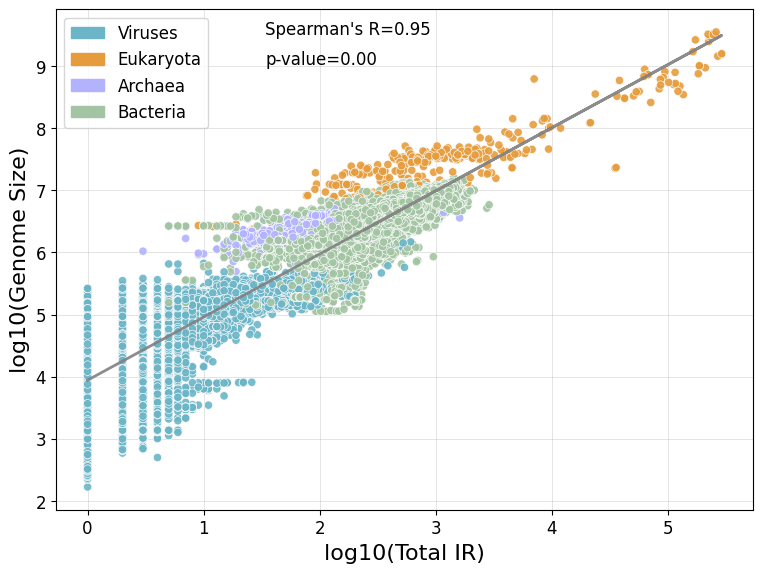

In [196]:
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6.5))

# xs = np.linspace(np.min(y_pred) - 0.1, np.max(y_pred) + 0.1, 200)
ax.plot(X, y_pred, color='gray', alpha=0.9, lw=2.0, zorder=3)
r, p = pearsonr(chunk['total_ir'], chunk['genome_size'])
ax.text(0.3, 0.95, 'Spearman\'s R={:.2f}'.format(r), fontsize=12, transform=ax.transAxes)
ax.text(0.3, 0.89, 'p-value={:.2f}'.format(p), fontsize=12, transform=ax.transAxes)
sns.scatterplot(
               data=chunk,
               x="total_ir",
               y="genome_size",
               hue="domain",
                marker='o',
                # size=14.0,
               ax=ax,
               palette=domain_colors,
               alpha=0.9,
               zorder=2
            )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_ylabel("log10(Genome Size)")
ax.set_xlabel("log10(Total IR)")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


ax.legend(handles=[mpatches.Patch(color=color, label=domain.capitalize()) for domain, color in domain_colors.items()],
                         frameon=True, 
                             fancybox=True, 
                             shadow=False, 
                              loc=0,
                             title="", 
                             prop={"size": 12})

ax.tick_params(axis="both", which="major", labelsize=12)
fig.savefig(f"{DATABASE}/total_ir_vs_genome_size_superkingdoms.png", bbox_inches='tight')

## IRP Domain Coverage

In [43]:
mean_irp_density_domain = grouped_genome_size.groupby("superkingdom", as_index=False)\
                                             .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                              )

mean_irp_density_domain.to_csv(f"{DATABASE}/mean_coverage_ir_domain_level.csv")
mean_irp_density_domain['superkingdom'] = pd.Categorical(
                                                        mean_irp_density_domain['superkingdom'],                                                         
                                                        ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
                                            )
mean_irp_density_domain.sort_values(by=["superkingdom"], inplace=True)
mean_irp_density_domain

,superkingdom,mean_coverage,std_err_coverage
0,Archaea,1134.028867,39.251451
2,Eukaryota,1544.136618,154.164281
1,Bacteria,3238.268432,8.386712
3,Viruses,1890.777915,18.621931


In [158]:
df_merged[df_merged['superkingdom'] == 'Eukaryota']['sequenceLength'].sum(), irp_df[irp_df['superkingdom'] == 'Eukaryota']['sequenceLength'].sum()

(174592968, 200704024)

In [49]:
mean_irp_density_domain = grouped_genome_size_or.groupby("superkingdom", as_index=False)\
                                             .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                              )

mean_irp_density_domain.to_csv(f"{DATABASE}/mean_coverage_ir_domain_level.csv")
mean_irp_density_domain['superkingdom'] = pd.Categorical(
                                                        mean_irp_density_domain['superkingdom'],                                                         
                                                        ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
                                            )
mean_irp_density_domain.sort_values(by=["superkingdom"], inplace=True)
mean_irp_density_domain

,superkingdom,mean_coverage,std_err_coverage
0,Archaea,1134.028867,39.251451
2,Eukaryota,1544.136618,154.164281
1,Bacteria,3238.268432,8.386712
3,Viruses,1890.107872,18.615834


In [174]:
df_merged.groupby("superkingdom")['sequenceLength'].sum(), irp_df.groupby("superkingdom")["sequenceLength"].sum()

(superkingdom
 Archaea        2422484
 Bacteria     651207969
 Eukaryota    174592968
 Viruses        5324659
 Name: sequenceLength, dtype: int64,
 superkingdom
 Archaea        2430463
 Bacteria     652083869
 Eukaryota    200704024
 Viruses        5408462
 Name: sequenceLength, dtype: int64)

In [50]:
mean_irp_density_domain = grouped_genome_size.groupby("superkingdom", as_index=False)\
                                             .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                              )

mean_irp_density_domain.to_csv(f"{DATABASE}/mean_coverage_ir_domain_level.csv")
mean_irp_density_domain['superkingdom'] = pd.Categorical(
                                                        mean_irp_density_domain['superkingdom'],                                                         
                                                        ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
                                            )
mean_irp_density_domain.sort_values(by=["superkingdom"], inplace=True)
mean_irp_density_domain

,superkingdom,mean_coverage,std_err_coverage
0,Archaea,1129.865915,39.121162
2,Eukaryota,1393.592709,122.091131
1,Bacteria,3231.288424,8.277416
3,Viruses,1877.803022,18.502651


In [199]:
mean_irp_density_domain = grouped_genome_size.groupby("superkingdom", as_index=False)\
                                             .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                              )

mean_irp_density_domain.to_csv(f"{DATABASE}/mean_coverage_ir_domain_level.csv")
mean_irp_density_domain['superkingdom'] = pd.Categorical(
                                                        mean_irp_density_domain['superkingdom'],                                                         
                                                        ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
                                            )
mean_irp_density_domain.sort_values(by=["superkingdom"], inplace=True)
mean_irp_density_domain

,superkingdom,mean_coverage,std_err_coverage
0,Archaea,1.149409,0.039677
2,Eukaryota,1.611118,0.161863
1,Bacteria,3.253642,0.008500
3,Viruses,1.903630,0.018706


In [52]:
# grouped_genome_size.loc[:, "coverage_mb"] = grouped_genome_size["coverage"] * 1e3

/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


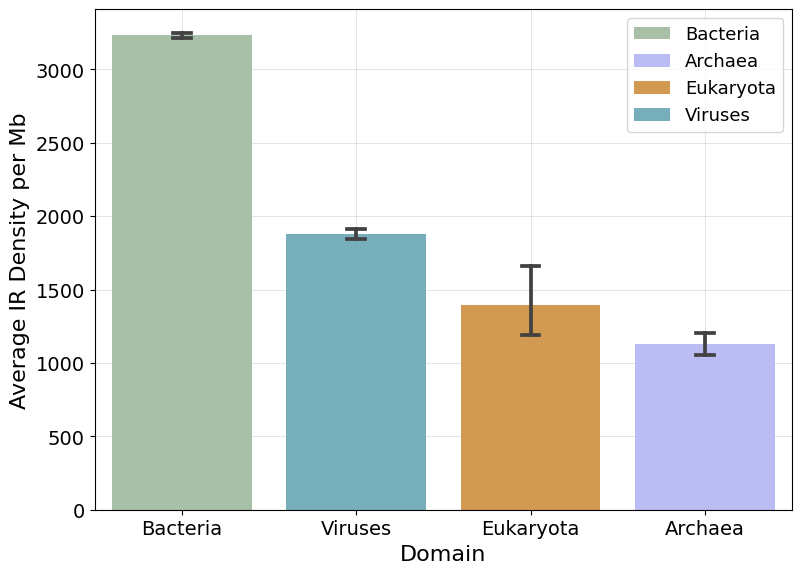

In [54]:
fig = plt.figure(figsize=(9, 6.5)) 
ax = sns.barplot(
                 x='superkingdom', 
                 y='coverage', 
                 # width=0.6, 
                 data=grouped_genome_size, 
                 hue="superkingdom", 
                 dodge=False,
                 # height=0.5,
                 # aspect=0.4,
                 # errwidth=2.0,
                 capsize = 0.1,
                 # legend=True,
                 palette=domain_colors,
                 order=["Bacteria", "Viruses", "Eukaryota", "Archaea"],
                 alpha=1.0
            )

ax.xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)
# # ax.errorbar(x=x_coords, y=y_coords, yerr=mean_irp_density_domain["std_err_coverage"], fmt="none", c="k", zorder=1)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.set_xlabel("Domain")
ax.set_ylabel("Average IR Density per Mb")
ax.xaxis.label.set_size(16)
legend = ax.legend(prop={"size": 13}, 
                   fancybox=True, 
                   shadow=False, 
                   title='')
plt.setp(legend.get_title(),fontsize=14)


ax.yaxis.label.set_size(16)
ax.tick_params(axis="both",  which="major", labelsize=14)
fig.savefig(f"{DATABASE}/irp_coverage_barplot_superkingdoms.png", bbox_inches='tight')
plt.show()

# IR Coverage Filter By GC

In [70]:
all_assemblies = pd.concat([
                            irp_df[["#assembly_accession", "superkingdom", "kingdom"]].drop_duplicates(),
                            empty_accessions_df[['#assembly_accession', 'superkingdom', "kingdom"]].drop_duplicates()
                        ], 
                    axis=0)\
                 .reset_index(drop=True)

print(len(all_assemblies))
all_assemblies.head()

118065


,#assembly_accession,superkingdom,kingdom
0,GCA_000007325.1,Bacteria,Eubacteria
1,GCA_000007385.1,Bacteria,Eubacteria
2,GCA_000008005.1,Bacteria,Eubacteria
3,GCA_000008085.1,Archaea,Archaeabacteria
4,GCA_000008885.1,Bacteria,Eubacteria


In [71]:
unique_assemblies = set(all_assemblies['#assembly_accession'])
len(unique_assemblies)

118065

In [69]:
from collections import defaultdict
from tqdm import tqdm

step_size = 0.02
thresholds = np.arange(0.0, 1.02, step_size)
thresholded_marks = {}

for domain in domains:
    thresholded_marks[domain] = defaultdict(list)

total_assemblies = len(all_assemblies)

for threshold in tqdm(thresholds, leave=True, position=0, total=len(thresholds)):

    thresholded = irp_df.query(f"gc_content >= {threshold}")
    grouped_genome_size = thresholded.groupby("#assembly_accession")\
                                        .agg({
                                                          "sequenceLength": "sum", 
                                                          "genome_size": "first",
                                                          "superkingdom": "first",
                                        })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength']).div(df['genome_size']))\
                            .drop(columns=['sequenceLength', 'genome_size'])

    seen_assemblies = set(grouped_genome_size.index)
    unseen_assemblies =  unique_assemblies - seen_assemblies

    unseen_assemblies = pd.DataFrame(unseen_assemblies)
    unseen_assemblies.columns = ['#assembly_accession']

    unseen_assemblies = unseen_assemblies.merge(
                                                all_assemblies.drop(columns=['kingdom']), 
                                                how="left", 
                                                on="#assembly_accession"
                                               )

    assert "#assembly_accession" in unseen_assemblies and "superkingdom" in unseen_assemblies
    assert len(unseen_assemblies.columns) == len(grouped_genome_size.columns)
    
    unseen_assemblies.set_index("#assembly_accession", inplace=True)
    unseen_assemblies.loc[:, "coverage"] = 0.0
    
    grouped_genome_size = pd.concat([
                    grouped_genome_size, 
                    unseen_assemblies
                ], axis=0)

    assert grouped_genome_size.shape[0] == total_assemblies
    assert grouped_genome_size.query("coverage == 0.0").shape[0] == unseen_assemblies.shape[0]
    
    mean_irp_density_domain = grouped_genome_size.groupby("superkingdom")\
                                            .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                            )
    
    for domain in domains:
        domain_irp = mean_irp_density_domain.loc[domain]["mean_coverage"]
        domain_std = mean_irp_density_domain.loc[domain]["std_err_coverage"]
        thresholded_marks[domain]["threshold"].append(threshold)
        thresholded_marks[domain]["irp_coverage"].append(domain_irp)
        thresholded_marks[domain]["std_err_coverage"].append(domain_std)

100%|██████████| 51/51 [03:39<00:00,  4.31s/it]


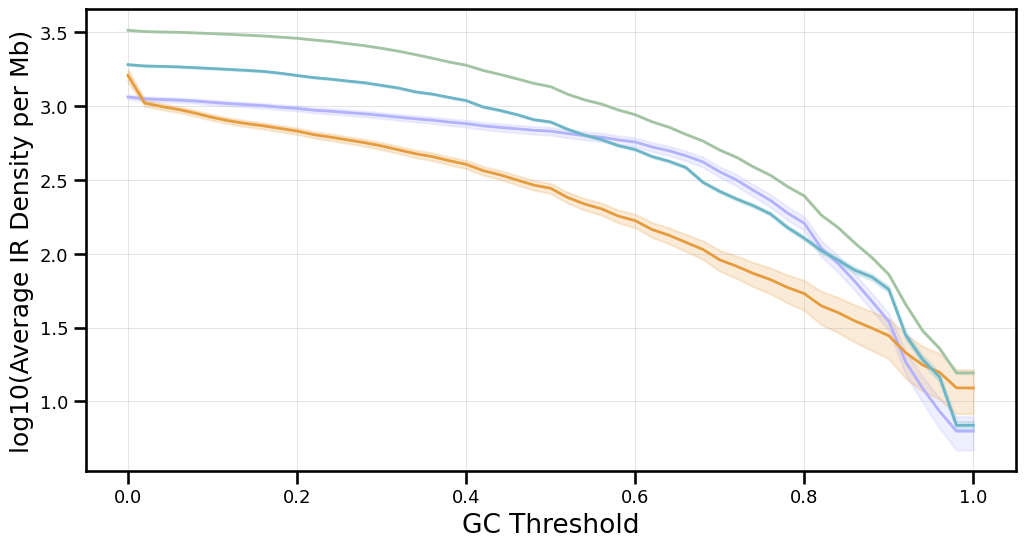

In [159]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
deviations = 1.0
flog = lambda y: list(map(lambda x: math.log(x+1, 10), y))
for domain in domains:
    ax.plot(thresholded_marks[domain]["threshold"], 
            flog(thresholded_marks[domain]["irp_coverage"]), 
            color=domain_colors[domain], 
            zorder=3,
           lw=2.0,
           )
    ax.fill_between(thresholded_marks[domain]["threshold"], 
                    flog(np.array(thresholded_marks[domain]["irp_coverage"]) - deviations * np.array(thresholded_marks[domain]["std_err_coverage"])),
                    flog(np.array(thresholded_marks[domain]["irp_coverage"]) + deviations * np.array(thresholded_marks[domain]["std_err_coverage"])),
                    alpha=0.2, 
                    color=domain_colors[domain]
                          )
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("GC Threshold")
    ax.xaxis.label.set_size(19)
    ax.yaxis.label.set_size(18)
    ax.set_ylabel("log10(Average IR Density per Mb)")
    ax.tick_params(axis="both", which="major", labelsize=13)
    
fig.savefig(f"{DATABASE}/IR_coverage_vs_GC_threshold_domains.png", bbox_inches='tight')

## Thresholds for kingdoms

In [35]:
# kingdom_color_palette = { "Viruses": "#87c4c4",
#                          "Bacteria": "#0fbf2d",
#                          "Archaea": "#7b7bed",
#                          "Fungi": "#4d325e",
#                          "Plantae": "#b50996",
#                         "Animalia": "#9bba2d",
#                         "Protista": "#c78f5b",
#                         "Eubacteria": "#0fbf2d",
#                         "Archaeabacteria": "#7b7bed",
#                 } 

In [55]:
irp_df.loc[:, "reduced_kingdom"] = irp_df["kingdom"].apply(lambda y: y if y in kingdom_color_palette else "Viruses")

In [56]:
irp_df.loc[:, "gc_content"] = irp_df["sequence"].apply(lambda seq: (seq.count("g") + seq.count("c")) / len(seq))

In [57]:
irp_df.head().iloc[0]

seqID                                                         AE009951.2
start                                                              17161
end                                                                17183
sequenceOfArm                                                 gtaaaagttt
sequenceOfSpacer                                                      ct
sequence                                          gtaaaagtttctaaacttttac
armLength                                                             10
spacerLength                                                           2
sequenceLength                                                        22
arm_a                                                                  4
arm_g                                                                  2
arm_c                                                                  0
arm_t                                                                  4
composition                                        

In [58]:
kingdoms = irp_df['reduced_kingdom'].unique().tolist()
kingdoms

['Eubacteria',
 'Archaeabacteria',
 'Fungi',
 'Viruses',
 'Plantae',
 'Protista',
 'Animalia']

In [83]:
from collections import defaultdict

kingdom_color_palette.update({"Eubacteria": "#0fbf2d", "Archaeabacteria": "#7b7bed"})

step_size = 0.02
thresholds = np.arange(0.0, 1.02, step_size)
thresholded_kingdoms = {}

for kingdom in kingdoms:
    thresholded_kingdoms[kingdom] = defaultdict(list)
total_assemblies = len(all_assemblies)

for threshold in tqdm(thresholds, leave=True, position=0, total=len(thresholds)):

    thresholded = irp_df.query(f"gc_content >= {threshold}")
    grouped_genome_size = thresholded[thresholded['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})]\
                                    .groupby("#assembly_accession")\
                                        .agg({
                                                          "sequenceLength": "sum", 
                                                          "genome_size": "first",
                                                          "kingdom": "first"
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength']).div(df['genome_size']))\
                            .drop(columns=['sequenceLength', 'genome_size'])

    seen_assemblies = set(grouped_genome_size.index)
    unseen_assemblies =  unique_assemblies - seen_assemblies

    unseen_assemblies = pd.DataFrame(unseen_assemblies)
    unseen_assemblies.columns = ['#assembly_accession']

    unseen_assemblies = unseen_assemblies.merge(
                                                all_assemblies[["#assembly_accession", "kingdom"]], 
                                                how="left", 
                                                on="#assembly_accession"
                                               )

    assert "#assembly_accession" in unseen_assemblies and "kingdom" in unseen_assemblies
    assert len(unseen_assemblies.columns) == len(grouped_genome_size.columns)
    
    unseen_assemblies.set_index("#assembly_accession", inplace=True)
    unseen_assemblies.loc[:, "coverage"] = 0.0
    
    grouped_genome_size = pd.concat([grouped_genome_size, unseen_assemblies], axis=0)

    assert grouped_genome_size.shape[0] == total_assemblies
    assert grouped_genome_size.query("coverage == 0.0").shape[0] == unseen_assemblies.shape[0]
    
    grouped_genome_size["kingdom"] = grouped_genome_size["kingdom"].apply(lambda y: y if y in kingdom_color_palette else "Viruses")
    
    mean_irp_density_kingdom = grouped_genome_size.groupby("kingdom")\
                                            .agg(
                                                mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / ds.shape[0] ** 0.5)
                                                )
    
    for kingdom in kingdoms:
        kingdom_irp = mean_irp_density_kingdom.loc[kingdom]["mean_coverage"]
        kingdom_std = mean_irp_density_kingdom.loc[kingdom]["std_err_coverage"]
        thresholded_kingdoms[kingdom]["threshold"].append(threshold)
        thresholded_kingdoms[kingdom]["irp_coverage"].append(kingdom_irp)
        thresholded_kingdoms[kingdom]["std_err_coverage"].append(kingdom_std)

 14%|█▎        | 7/51 [02:20<14:41, 20.04s/it]

KeyboardInterrupt



In [ ]:
thresholded_kingdoms.keys()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
deviations = 1.0

flog = lambda y: list(map(lambda x: math.log(x+1, 10), y))
kingdoms = {
            "Archaeabacteria", 
            "Eubacteria", 
            "Fungi", 
            "Plantae", 
            "Protista",
            "Animalia", 
            "Viruses"
        }

for kingdom in kingdoms:
    ax.plot(thresholded_kingdoms[kingdom]["threshold"], 
            flog(thresholded_kingdoms[kingdom]["irp_coverage"]), 
                        color=kingdom_color_palette[kingdom], zorder=3)
    ax.fill_between(thresholded_kingdoms[kingdom]["threshold"], 
                        flog(np.array(thresholded_kingdoms[kingdom]["irp_coverage"]) - deviations * np.array(thresholded_kingdoms[kingdom]["std_err_coverage"])),
                        flog(np.array(thresholded_kingdoms[kingdom]["irp_coverage"]) + deviations * np.array(thresholded_kingdoms[kingdom]["std_err_coverage"])),
                                    alpha=0.2, 
                        color=kingdom_color_palette[kingdom]
                          )
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("GC Threshold")
    ax.xaxis.label.set_size(19)
    ax.yaxis.label.set_size(18)
    ax.set_ylabel("log10(Average IR Density per Mb)")
    ax.tick_params(axis="both", which="major", labelsize=14)
    
fig.savefig(f"{DATABASE}/IR_coverage_vs_GC_threshold_kingdoms.png", bbox_inches='tight')

## IRP Kingdom Coverage

In [ ]:
kingdom_color_palette = {
                         "Viruses": "#87c4c4",
                         "Bacteria": "#0fbf2d",
                         "Archaea": "#7b7bed",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                         "Animalia": "#9bba2d",
                         "Protista": "#c78f5b"
                } 

In [89]:
grouped_genome_size = df_merged.groupby("#assembly_accession").agg({
                                                          "sequenceLength": "sum",
                                                          "phylum": "first",
                                                          "kingdom": "first",
                                                          "superkingdom": "first",
                                                         "genome_size": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * df['sequenceLength'].div(df['genome_size']))\
                            .drop(columns=['sequenceLength'])

grouped_genome_size = pd.concat([
                                     grouped_genome_size, 
                                     empty_accessions_df.set_index("#assembly_accession")\
                                [["genome_size", "phylum", "kingdom", "superkingdom"]]
                                ], 
                        axis=0)
grouped_genome_size['coverage'] = grouped_genome_size['coverage'].replace(np.nan, 0.0)
grouped_genome_size

,phylum,kingdom,superkingdom,genome_size,coverage
#assembly_accession,,,,,
GCA_000007325.1,Fusobacteriota,Eubacteria,Bacteria,2174500,3088.066222
GCA_000007385.1,Pseudomonadota,Eubacteria,Bacteria,4941439,2185.395793
GCA_000008005.1,Bacillota,Eubacteria,Bacteria,5432652,8280.670288
GCA_000008085.1,Nanoarchaeota,Archaeabacteria,Archaea,490885,843.374721
GCA_000008885.1,Pseudomonadota,Eubacteria,Bacteria,703004,8864.814425
...,...,...,...,...,...
GCA_004056615.1,Cressdnaviricota,Shotokuvirae,Viruses,1767,0.000000
GCA_031137045.1,Pisuviricota,Orthornavirae,Viruses,7559,0.000000
GCF_018589485.1,Artverviricota,Pararnavirae,Viruses,8203,0.000000


In [90]:
mean_irp_density_kingdom = grouped_genome_size.groupby("kingdom", as_index=False)\
                                            .agg(
                                                 median_coverage=("coverage", "median"),
                                                 mean_coverage=("coverage", "mean"),
                                                 std_err_coverage=("coverage", lambda ds: ds.std() / (ds.shape[0] ** 0.5) ),
                                                 domain=("superkingdom", "first"),
                                                 total_species=("superkingdom", "count"),

                                                )\
                                        .assign(kingdom_color=lambda df: df[["domain", "kingdom"]].apply(lambda y: kingdom_color_palette[y['domain']] if y['domain'] in {"Viruses", "Archaea", "Bacteria"} \
                                                                                                                   else kingdom_color_palette[y['kingdom']], axis=1))\
                                        .dropna(subset=['std_err_coverage'])\
                                        .sort_values(by=["mean_coverage"], ascending=False)\
                                        .reset_index(drop=True)\
                                        .query("kingdom != 'Unclassified Viruses'")


mean_irp_density_kingdom.to_csv(f"{DATABASE}/mean_coverage_ir_kingdom_level.csv")
mean_irp_density_kingdom

,kingdom,median_coverage,mean_coverage,std_err_coverage,domain,total_species,kingdom_color
0,Protista,1432.469739,3992.327122,1541.013560,Eukaryota,30,#c78f5b
1,Plantae,3365.268982,3467.282618,379.968293,Eukaryota,39,#b50996
3,Eubacteria,2891.408128,3231.288424,8.277416,Bacteria,49197,#0fbf2d
4,Animalia,1989.408776,3062.795056,420.978600,Eukaryota,22,#9bba2d
5,Shotokuvirae,0.000000,2981.097534,73.651060,Viruses,8733,#87c4c4
6,Sangervirae,0.000000,2962.347443,68.805836,Viruses,4380,#87c4c4
7,Loebvirae,0.000000,2634.755186,196.764986,Viruses,363,#87c4c4
8,Trapavirae,1294.726930,1494.124118,457.003373,Viruses,21,#87c4c4
9,Helvetiavirae,909.531894,1381.348826,473.748746,Viruses,10,#87c4c4
10,Zilligvirae,1014.113074,1333.692086,211.740800,Viruses,37,#87c4c4


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


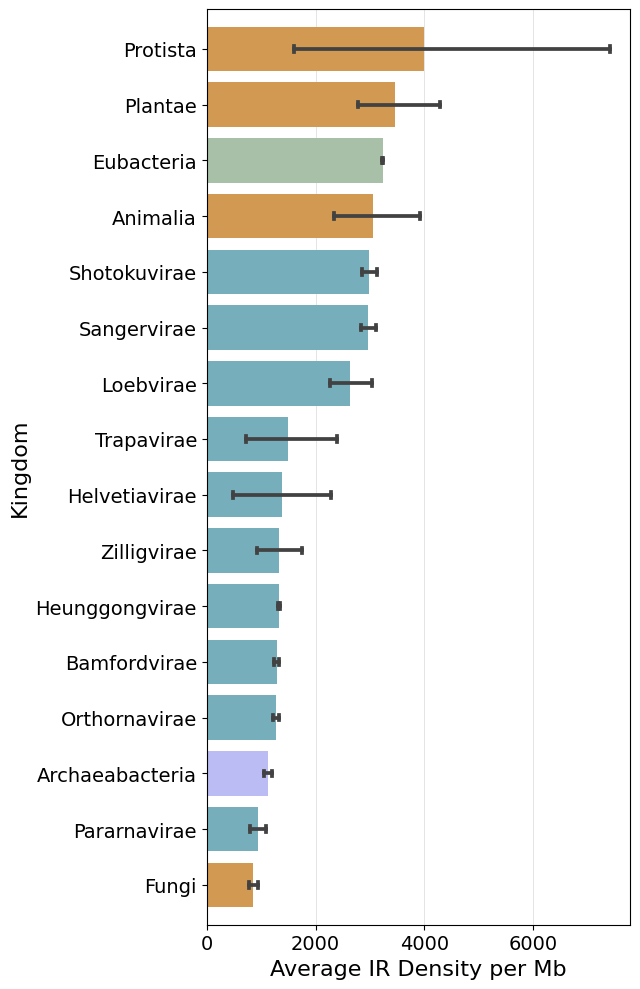

In [64]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 10))
kingdom_palette = mean_irp_density_kingdom.set_index("kingdom")["kingdom_color"].to_dict()
grouped_genome_size = grouped_genome_size[grouped_genome_size['kingdom'] != 'Unclassified Viruses']
sns.barplot(x='coverage', 
            y='kingdom', 
            orient="h", 
            # width=0.5,
            dodge=False,
            # xerr=mean_irp_density_kingdom['std_err_coverage'] * 0.5,
            # errorbar=('ci', .95), 
            capsize=0.1,
            data=grouped_genome_size, 
            hue="superkingdom", 
            order=grouped_genome_size.groupby("kingdom").agg({"coverage": "mean"}).sort_values(by=['coverage'], ascending=False).index,
            palette=domain_colors,
                 ax=ax,
                 alpha=1.0
           )

ax.xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)

ax.set_ylabel("Kingdom")
ax.yaxis.label.set_size(16)
ax.legend(title="", frameon=False, handles=[], bbox_to_anchor=(.35, 0.2), shadow=False, prop={"size": 18})
# ax.set_xlim(0, 15.0)
ax.set_xlabel(r"Average IR Density per Mb")
ax.xaxis.label.set_size(16)
ax.tick_params(axis="both",  which="major", labelsize=14)
ax.set_axisbelow(True)
ax.margins(y=0.02)

plt.tight_layout()
fig.savefig(f"{DATABASE}/ir_coverage_over_kingdoms.png", bbox_inches='tight')

In [67]:
def thresholded_ir_density(gc_threshold):
    grouped_genome_size = irp_df.query(f"gc_content > {gc_threshold}").groupby("#assembly_accession", as_index=False).agg({
                                                          "sequenceLength": "sum",
                                                          "genome_size": "first",
                                                          "phylum": "first",
                                                          "kingdom": "first",
                                                          "superkingdom": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength']).div(df['genome_size']))\
                            .drop(columns=['sequenceLength', 'genome_size'])

    grouped_genome_size = grouped_genome_size[grouped_genome_size['kingdom'] != 'Unclassified Viruses']
    seen_assemblies = set(grouped_genome_size['#assembly_accession'])
    
    empty_assemblies = all_assemblies[(~all_assemblies['#assembly_accession'].isin(seen_assemblies)) & (all_assemblies['kingdom'] != 'Unclassified Viruses')]
    grouped_genome_size = pd.concat([grouped_genome_size, empty_assemblies], axis=0)

    print(grouped_genome_size.shape, all_assemblies.shape, empty_assemblies.shape)
    assert grouped_genome_size.shape[0] == all_assemblies[all_assemblies['kingdom'] != 'Unclassified Viruses'].shape[0]
    grouped_genome_size['coverage'] = grouped_genome_size['coverage'].replace(np.nan, 0.0)

    grouped_genome_size = grouped_genome_size.assign(kingdom_color=lambda df: df[["superkingdom", "kingdom"]]\
                                             .apply(lambda y: kingdom_color_palette[y['superkingdom']] if y['superkingdom'] in {"Viruses", "Archaea", "Bacteria"} \
                                                            else kingdom_color_palette[y['kingdom']], axis=1)
                                                    )

    return grouped_genome_size
    
    mean_irp_density_kingdom = grouped_genome_size.groupby("kingdom", as_index=False)\
                                                .agg(median_coverage=("coverage", "median"),
                                                     mean_coverage=("coverage", "mean"),
                                                     std_err_coverage=("coverage", lambda ds: ds.std() / (ds.shape[0] ** 0.5) ),
                                                     domain=("superkingdom", "first"),
                                                     total_species=("superkingdom", "count"),
    
                                                    )\
                                            .assign(kingdom_color=lambda df: df[["domain", "kingdom"]].apply(lambda y: kingdom_color_palette[y['domain']] if y['domain'] in {"Viruses", "Archaea", "Bacteria"} \
                                                                                                                       else kingdom_color_palette[y['kingdom']], axis=1))\
                                            .dropna(subset=['std_err_coverage'])\
                                            .sort_values(by=["mean_coverage"], ascending=False)\
                                            .reset_index(drop=True)\
                                            .query("kingdom != 'Unclassified Viruses'")
    
    return mean_irp_density_kingdom

(109827, 5) (118065, 3) (29084, 3)


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


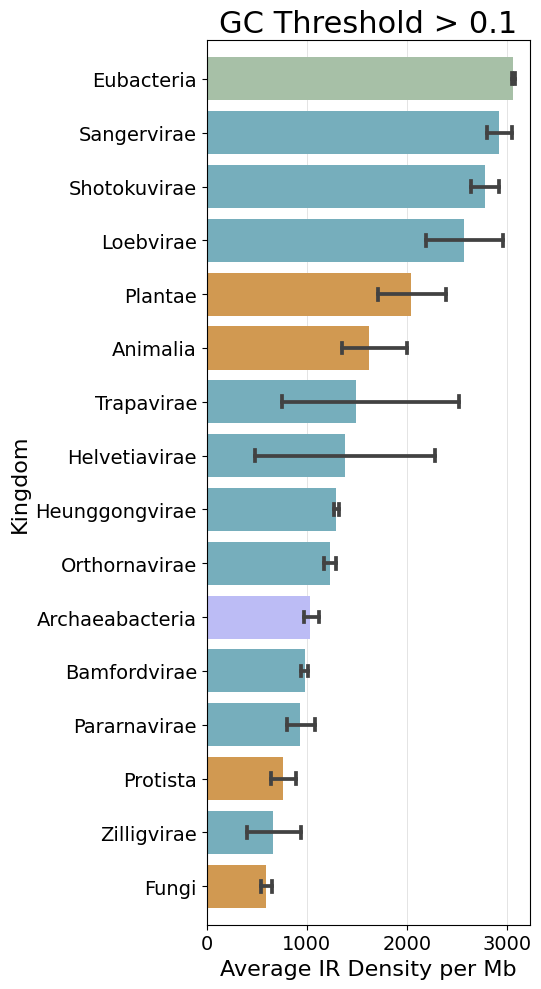

(109827, 5) (118065, 3) (30414, 3)


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


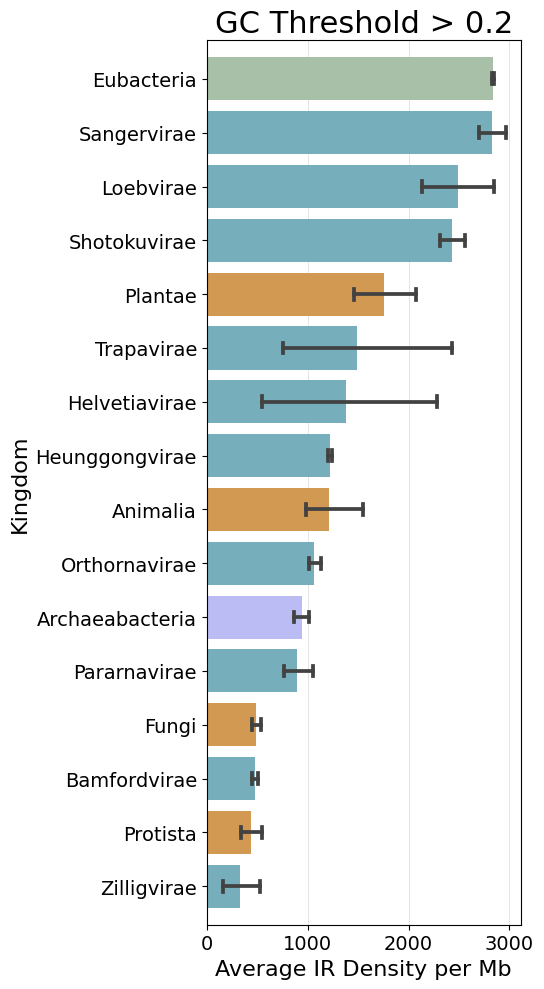

(109827, 5) (118065, 3) (32361, 3)


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


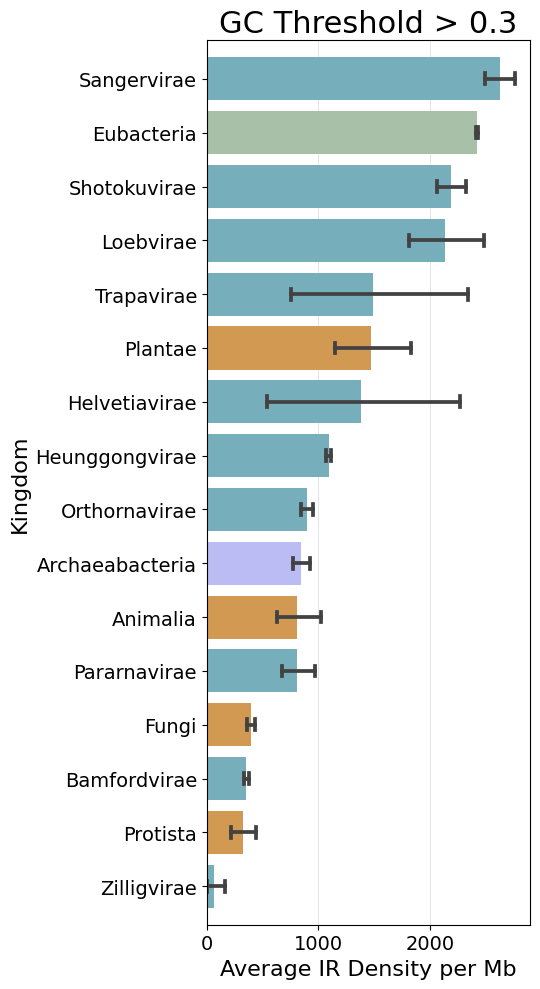

In [72]:
gc_thresholds = [0.1, 0.2, 0.3]
for gc_threshold in gc_thresholds:
    mean_irp_density_kingdom = thresholded_ir_density(gc_threshold)
    # mean_irp_density_kingdom.to_csv(f"{DATABASE}/mean_coverage_ir_kingdom_level_gc>{gc_threshold}.csv")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 10))
    kingdom_palette = mean_irp_density_kingdom.set_index("kingdom")["kingdom_color"].to_dict()
    sns.barplot(x='coverage', 
                y='kingdom', 
                orient="h", 
                # width=0.5,
                dodge=False,
                capsize=0.2,
                # errorbar=('ci', .95), 
                data=mean_irp_density_kingdom, 
                hue="superkingdom", 
                palette=domain_colors,
                order=mean_irp_density_kingdom.groupby("kingdom").agg({"coverage": "mean"}).sort_values(by=['coverage'], ascending=False).index,
                ax=ax,
                alpha=1.0
               )
    
    ax.xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)
    ax.set_title(f"GC Threshold > {gc_threshold}")
    ax.title.set_size(22)
    ax.set_ylabel("Kingdom")
    ax.yaxis.label.set_size(16)
    ax.legend(title="", frameon=False, handles=[], bbox_to_anchor=(.35, 0.2), shadow=False, prop={"size": 18})
    # ax.set_xlim(0, 15.0)
    ax.set_xlabel(r"Average IR Density per Mb")
    ax.xaxis.label.set_size(16)
    ax.tick_params(axis="both",  which="major", labelsize=14)
    ax.set_axisbelow(True)
    ax.margins(y=0.02)
    
    plt.tight_layout()
    fig.savefig(f"{DATABASE}/ir_coverage_over_kingdoms_gc_above_{gc_threshold}.png", bbox_inches='tight')
    plt.show()

## IRP Phylum Coverage

In [73]:
grouped_genome_size = df_merged.groupby("#assembly_accession").agg({
                                                          "sequenceLength": "sum",
                                                          "genome_size": "first",
                                                          "phylum": "first",
                                                          "kingdom": "first",
                                                          "superkingdom": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength']).div(df['genome_size']))\
                            .drop(columns=['sequenceLength'])

grouped_genome_size = pd.concat([
                                grouped_genome_size, 
                                 empty_accessions_df.set_index("#assembly_accession")[["genome_size", "phylum", "kingdom", "superkingdom"]]
                                ], 
                        axis=0)
grouped_genome_size['coverage'] = grouped_genome_size['coverage'].replace(np.nan, 0.0)

In [101]:
grouped_genome_size_or = irp_df.groupby("#assembly_accession").agg({
                                                          "sequenceLength": "sum",
                                                          "genome_size": "first",
                                                          "phylum": "first",
                                                          "kingdom": "first",
                                                          "superkingdom": "first",
                                    })\
                            .assign(coverage=lambda df: 1e6 * (df['sequenceLength']).div(df['genome_size']))\
                            .drop(columns=['sequenceLength'])

grouped_genome_size_or = pd.concat([
                                grouped_genome_size_or, 
                                 empty_accessions_df.set_index("#assembly_accession")[["genome_size", "phylum", "kingdom", "superkingdom"]]
                                ], 
                        axis=0)
grouped_genome_size_or['coverage'] = grouped_genome_size_or['coverage'].replace(np.nan, 0.0)
grouped_genome_size_or

,genome_size,phylum,kingdom,superkingdom,coverage
#assembly_accession,,,,,
GCA_000007325.1,2174500,Fusobacteriota,Eubacteria,Bacteria,3091.285353
GCA_000007385.1,4941439,Pseudomonadota,Eubacteria,Bacteria,2193.288230
GCA_000008005.1,5432652,Bacillota,Eubacteria,Bacteria,8288.953535
GCA_000008085.1,490885,Nanoarchaeota,Archaeabacteria,Archaea,843.374721
GCA_000008885.1,703004,Pseudomonadota,Eubacteria,Bacteria,9092.409147
...,...,...,...,...,...
GCA_004056615.1,1767,Cressdnaviricota,Shotokuvirae,Viruses,0.000000
GCA_031137045.1,7559,Pisuviricota,Orthornavirae,Viruses,0.000000
GCF_018589485.1,8203,Artverviricota,Pararnavirae,Viruses,0.000000


In [102]:
mean_irp_density_phyla = grouped_genome_size_or.groupby("phylum", as_index=False)\
                                            .agg(mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / (ds.shape[0] ** 0.5) ),
                                                domain=("superkingdom", "first"),
                                                 total_species=("superkingdom", "count"),
                                                 kingdom=("kingdom", "first"),
                                                 
                                                )\
                                        .assign(kingdom_color=lambda df: df[["domain", "kingdom"]].apply(lambda y: kingdom_color_palette[y['domain']] if y['domain'] in {"Viruses", "Archaea", "Bacteria"} \
                                                                                                                   else kingdom_color_palette[y['kingdom']], axis=1))\
                                        .assign(kingdom=lambda df: df['kingdom'].apply(lambda y: "Viruses" if y not in {"Archaeabacteria", "Eubacteria", "Protista", "Animalia", "Plantae", "Fungi"} else y))\
                                        .dropna(subset=['std_err_coverage'])\
                                        .sort_values(by=["mean_coverage"], ascending=False)\
                                        .reset_index(drop=True)

mean_irp_density_phyla.to_csv(f"{DATABASE}/mean_coverage_ir_phylum_level.csv")
mean_irp_density_phyla.head(40)

,phylum,mean_coverage,std_err_coverage,domain,total_species,kingdom,kingdom_color
0,Candidatus Campbellbacteria,11581.480673,5523.869898,Bacteria,2,Eubacteria,#0fbf2d
1,Candidatus Kaiserbacteria,9581.870560,454.954519,Bacteria,2,Eubacteria,#0fbf2d
2,Apicomplexa,7782.147073,3634.404872,Eukaryota,16,Protista,#c78f5b
3,Mycoplasmatota,5706.741395,114.143502,Bacteria,674,Eubacteria,#0fbf2d
4,Candidatus Nomurabacteria,5172.533932,1647.354890,Bacteria,6,Eubacteria,#0fbf2d
5,Candidatus Gracilibacteria,4895.481605,1628.698939,Bacteria,6,Eubacteria,#0fbf2d
6,Streptophyta,4859.864469,601.515876,Eukaryota,25,Plantae,#b50996
7,Candidatus Paceibacterota,4458.037133,651.133505,Bacteria,3,Eubacteria,#0fbf2d
8,Lenarviricota,4050.995867,188.287976,Viruses,1633,Viruses,#87c4c4
9,Bacillota,3877.728652,19.007245,Bacteria,10828,Eubacteria,#0fbf2d


In [74]:
mean_irp_density_phyla = grouped_genome_size.groupby("phylum", as_index=False)\
                                            .agg(mean_coverage=("coverage", "mean"),
                                                std_err_coverage=("coverage", lambda ds: ds.std() / (ds.shape[0] ** 0.5) ),
                                                domain=("superkingdom", "first"),
                                                 total_species=("superkingdom", "count"),
                                                 kingdom=("kingdom", "first"),
                                                 
                                                )\
                                        .assign(kingdom_color=lambda df: df[["domain", "kingdom"]].apply(lambda y: kingdom_color_palette[y['domain']] if y['domain'] in {"Viruses", "Archaea", "Bacteria"} \
                                                                                                                   else kingdom_color_palette[y['kingdom']], axis=1))\
                                        .assign(kingdom=lambda df: df['kingdom'].apply(lambda y: "Viruses" if y not in {"Archaeabacteria", "Eubacteria", "Protista", "Animalia", "Plantae", "Fungi"} else y))\
                                        .dropna(subset=['std_err_coverage'])\
                                        .sort_values(by=["mean_coverage"], ascending=False)\
                                        .reset_index(drop=True)

mean_irp_density_phyla.to_csv(f"{DATABASE}/mean_coverage_ir_phylum_level.csv")
mean_irp_density_phyla.head(40)

,phylum,mean_coverage,std_err_coverage,domain,total_species,kingdom,kingdom_color
0,Candidatus Campbellbacteria,11546.318909,5489.940608,Bacteria,2,Eubacteria,#0fbf2d
1,Candidatus Kaiserbacteria,9561.799001,471.233588,Bacteria,2,Eubacteria,#0fbf2d
2,Apicomplexa,6350.211317,2791.537383,Eukaryota,16,Protista,#c78f5b
3,Mycoplasmatota,5680.426606,113.442795,Bacteria,674,Eubacteria,#0fbf2d
4,Candidatus Nomurabacteria,5171.921117,1647.003172,Bacteria,6,Eubacteria,#0fbf2d
5,Candidatus Gracilibacteria,4892.731692,1627.509970,Bacteria,6,Eubacteria,#0fbf2d
6,Candidatus Paceibacterota,4447.436291,644.215973,Bacteria,3,Eubacteria,#0fbf2d
7,Streptophyta,4180.291800,484.115136,Eukaryota,25,Plantae,#b50996
8,Lenarviricota,4049.439341,188.128710,Viruses,1633,Viruses,#87c4c4
9,Bacillota,3873.584029,18.979626,Bacteria,10828,Eubacteria,#0fbf2d


In [75]:
top_phyla = set(mean_irp_density_phyla.iloc[:mean_irp_density_phyla.shape[0] // 2]['phylum'])
bottom_phyla = set(mean_irp_density_phyla.iloc[mean_irp_density_phyla.shape[0] // 2: ]['phylum'])

len(top_phyla), len(bottom_phyla)

(50, 51)

In [76]:
grouped_genome_size.loc[:, "kingdom"] = grouped_genome_size["kingdom"].apply(lambda y: y if y in {"Eubacteria", "Archaeabacteria", "Protista", "Fungi", "Plantae", "Animalia"} else "Viruses")

In [77]:
top_coverage_phylums = grouped_genome_size[grouped_genome_size['phylum'].isin(top_phyla)]
bottom_coverage_phylums = grouped_genome_size[grouped_genome_size['phylum'].isin(bottom_phyla)]

In [78]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'

/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

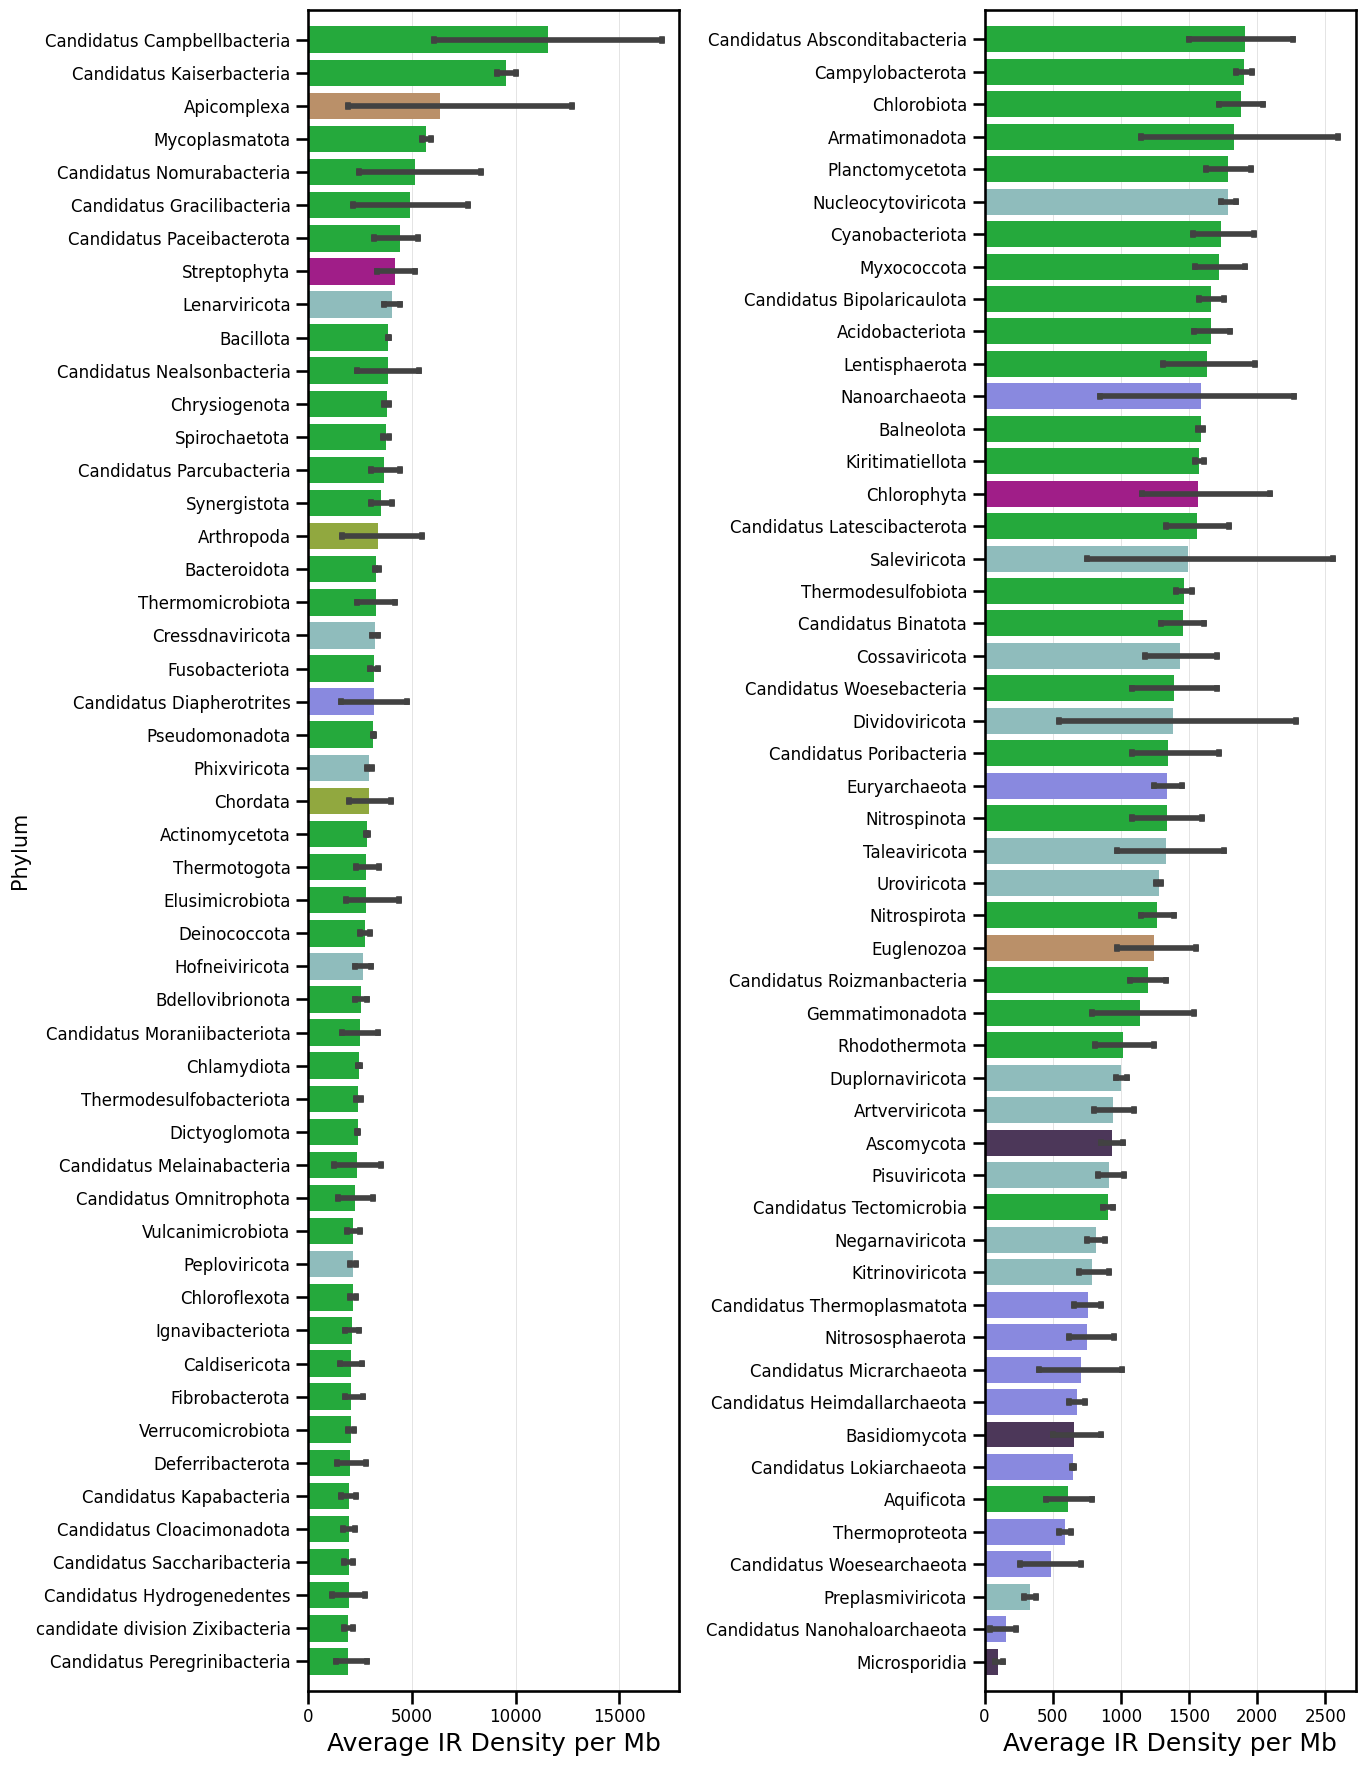

In [84]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 18))
sns.set_context("talk")
total = mean_irp_density_phyla.shape[0]
kingdom_palette = mean_irp_density_phyla.set_index("kingdom")["kingdom_color"].to_dict()

ay1 = sns.barplot(x='coverage', 
                  y='phylum', 
                  orient="h", 
                 # width=0.6, 
                 # errorbar=('ci', .95), 
                 data=top_coverage_phylums, 
                 hue="kingdom", 
                 dodge=False,
                 capsize=0.05,
                 palette=kingdom_palette,
                  order=top_coverage_phylums.groupby("phylum").agg({"coverage": "mean"}).sort_values(by=['coverage'], ascending=False).index,
                 #saturation=0.5,
                 ax=ax[0],
                 alpha=1.0
                 )
ay2 = sns.barplot(x='coverage', 
                  y='phylum', 
                  orient="h", 
                 # width=0.6, 
                 # errorbar=('ci', .95), 
                 dodge=False,
                  data=bottom_coverage_phylums,
                 hue="kingdom",
                 capsize=0.05,
                   order=bottom_coverage_phylums.groupby("phylum").agg({"coverage": "mean"}).sort_values(by=['coverage'], ascending=False).index,
                 palette=kingdom_palette,
                 ax=ax[1],
                 alpha=1.0
                 )
ay = [ay1, ay2]
for i in range(2):
        
    ax[i].xaxis.grid(True, linewidth=0.4, alpha=0.6, zorder=0)
    if i == 0:
        ax[i].set_ylabel("Phylum")
        ax[i].yaxis.label.set_size(15)
        ax[i].legend(handles=[], frameon=False)
    else:
        ax[i].set_ylabel("")
        # ax[i].legend(handles=[mpatches.Patch(color=color, label=kingdom.capitalize()) for kingdom, color in kingdom_color_palette.items()],
        #                    bbox_to_anchor=(0.6, 0.25), frameon=True, 
        #                     fancybox=True, 
        #                     shadow=False, 
        #                     title="Kingdom", 
        #                     title_fontsize='x-small', 
        #                     prop={"size": 5})
    ax[i].legend(handles=[], frameon=False, title="")
        
    # ax[i].set_xlim(0, 15.0)
    ax[i].set_xlabel("Average IR Density per Mb")
    
    ax[i].xaxis.label.set_size(18)
    ax[i].tick_params(axis="both",  which="major", labelsize=12)
    ax[i].set_axisbelow(True)
    ax[i].margins(y=0.01)
    
    # ax[i].set_ylim(ax[i].get_ylim()[0], ax[i].get_ylim()[1] - 2.0)
    
plt.tight_layout()
# fig.set_size_inches(20, 10)
fig.savefig(f"{DATABASE}/ir_coverage_over_phylums.png", bbox_inches='tight')

## Boxplot Phylum Analysis (More Descriptive in regards to Outliers)

In [91]:
kingdom_color_palette.update({"Eubacteria": '#0fbf2d', "Archaeabacteria": "#7b7bed"})
kingdom_color_palette

{'Viruses': '#87c4c4',
 'Bacteria': '#0fbf2d',
 'Archaea': '#7b7bed',
 'Fungi': '#4d325e',
 'Plantae': '#b50996',
 'Animalia': '#9bba2d',
 'Protista': '#c78f5b',
 'Eubacteria': '#0fbf2d',
 'Archaeabacteria': '#7b7bed'}

In [92]:
grouped_per_phylum = grouped_genome_size.dropna(subset=['phylum'], axis=0)
grouped_per_phylum.loc[:, "kingdom"] = grouped_per_phylum["kingdom"].apply(lambda kingdom: kingdom if kingdom in kingdom_color_palette else 'Viruses')
grouped_per_phylum

,phylum,kingdom,superkingdom,genome_size,coverage
#assembly_accession,,,,,
GCA_000007325.1,Fusobacteriota,Eubacteria,Bacteria,2174500,3088.066222
GCA_000007385.1,Pseudomonadota,Eubacteria,Bacteria,4941439,2185.395793
GCA_000008005.1,Bacillota,Eubacteria,Bacteria,5432652,8280.670288
GCA_000008085.1,Nanoarchaeota,Archaeabacteria,Archaea,490885,843.374721
GCA_000008885.1,Pseudomonadota,Eubacteria,Bacteria,703004,8864.814425
...,...,...,...,...,...
GCA_002587445.1,Phixviricota,Viruses,Viruses,5386,0.000000
GCA_004056615.1,Cressdnaviricota,Viruses,Viruses,1767,0.000000
GCA_031137045.1,Pisuviricota,Viruses,Viruses,7559,0.000000


In [93]:
median_phylum = grouped_per_phylum.groupby("phylum").agg(mean_coverage=("coverage", "mean")).sort_values(by=['mean_coverage'], ascending=False)
grouped_per_phylum = grouped_per_phylum.reset_index().merge(median_phylum, how="left", on="phylum")\
                        .set_index("#assembly_accession")\
                        .sort_values(by=["mean_coverage"], ascending=False)
grouped_per_phylum

,phylum,kingdom,superkingdom,genome_size,coverage,mean_coverage
#assembly_accession,,,,,,
GCA_016699465.1,Candidatus Campbellbacteria,Eubacteria,Bacteria,811376,6056.378301,11546.318909
GCA_001029775.1,Candidatus Campbellbacteria,Eubacteria,Bacteria,752630,17036.259517,11546.318909
GCA_017134395.1,Candidatus Kaiserbacteria,Eubacteria,Bacteria,687746,9090.565412,9561.799001
GCA_016699245.1,Candidatus Kaiserbacteria,Eubacteria,Bacteria,1054716,10033.032589,9561.799001
GCA_001029635.1,Candidatus Wolfebacteria,Eubacteria,Bacteria,984447,8626.162709,8626.162709
...,...,...,...,...,...,...
GCA_029207735.1,Candidatus Nanohaloarchaeota,Archaeabacteria,Archaea,948351,234.090542,154.335434
GCA_024399295.1,Microsporidia,Fungi,Eukaryota,2609445,95.805813,101.857928
GCA_024399255.1,Microsporidia,Fungi,Eukaryota,2707802,75.707160,101.857928


In [94]:
total_phyla = median_phylum.shape[0]
top_phyla = set(median_phylum.index.tolist()[:total_phyla // 2])
bottom_phyla = set(median_phylum.index.tolist()[total_phyla //2:])
len(top_phyla), len(bottom_phyla)

(64, 64)

In [95]:
top_grouped_phylum = grouped_per_phylum[grouped_per_phylum['phylum'].isin(top_phyla)]
bottom_grouped_phylum = grouped_per_phylum[grouped_per_phylum['phylum'].isin(bottom_phyla)]

In [96]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'

/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

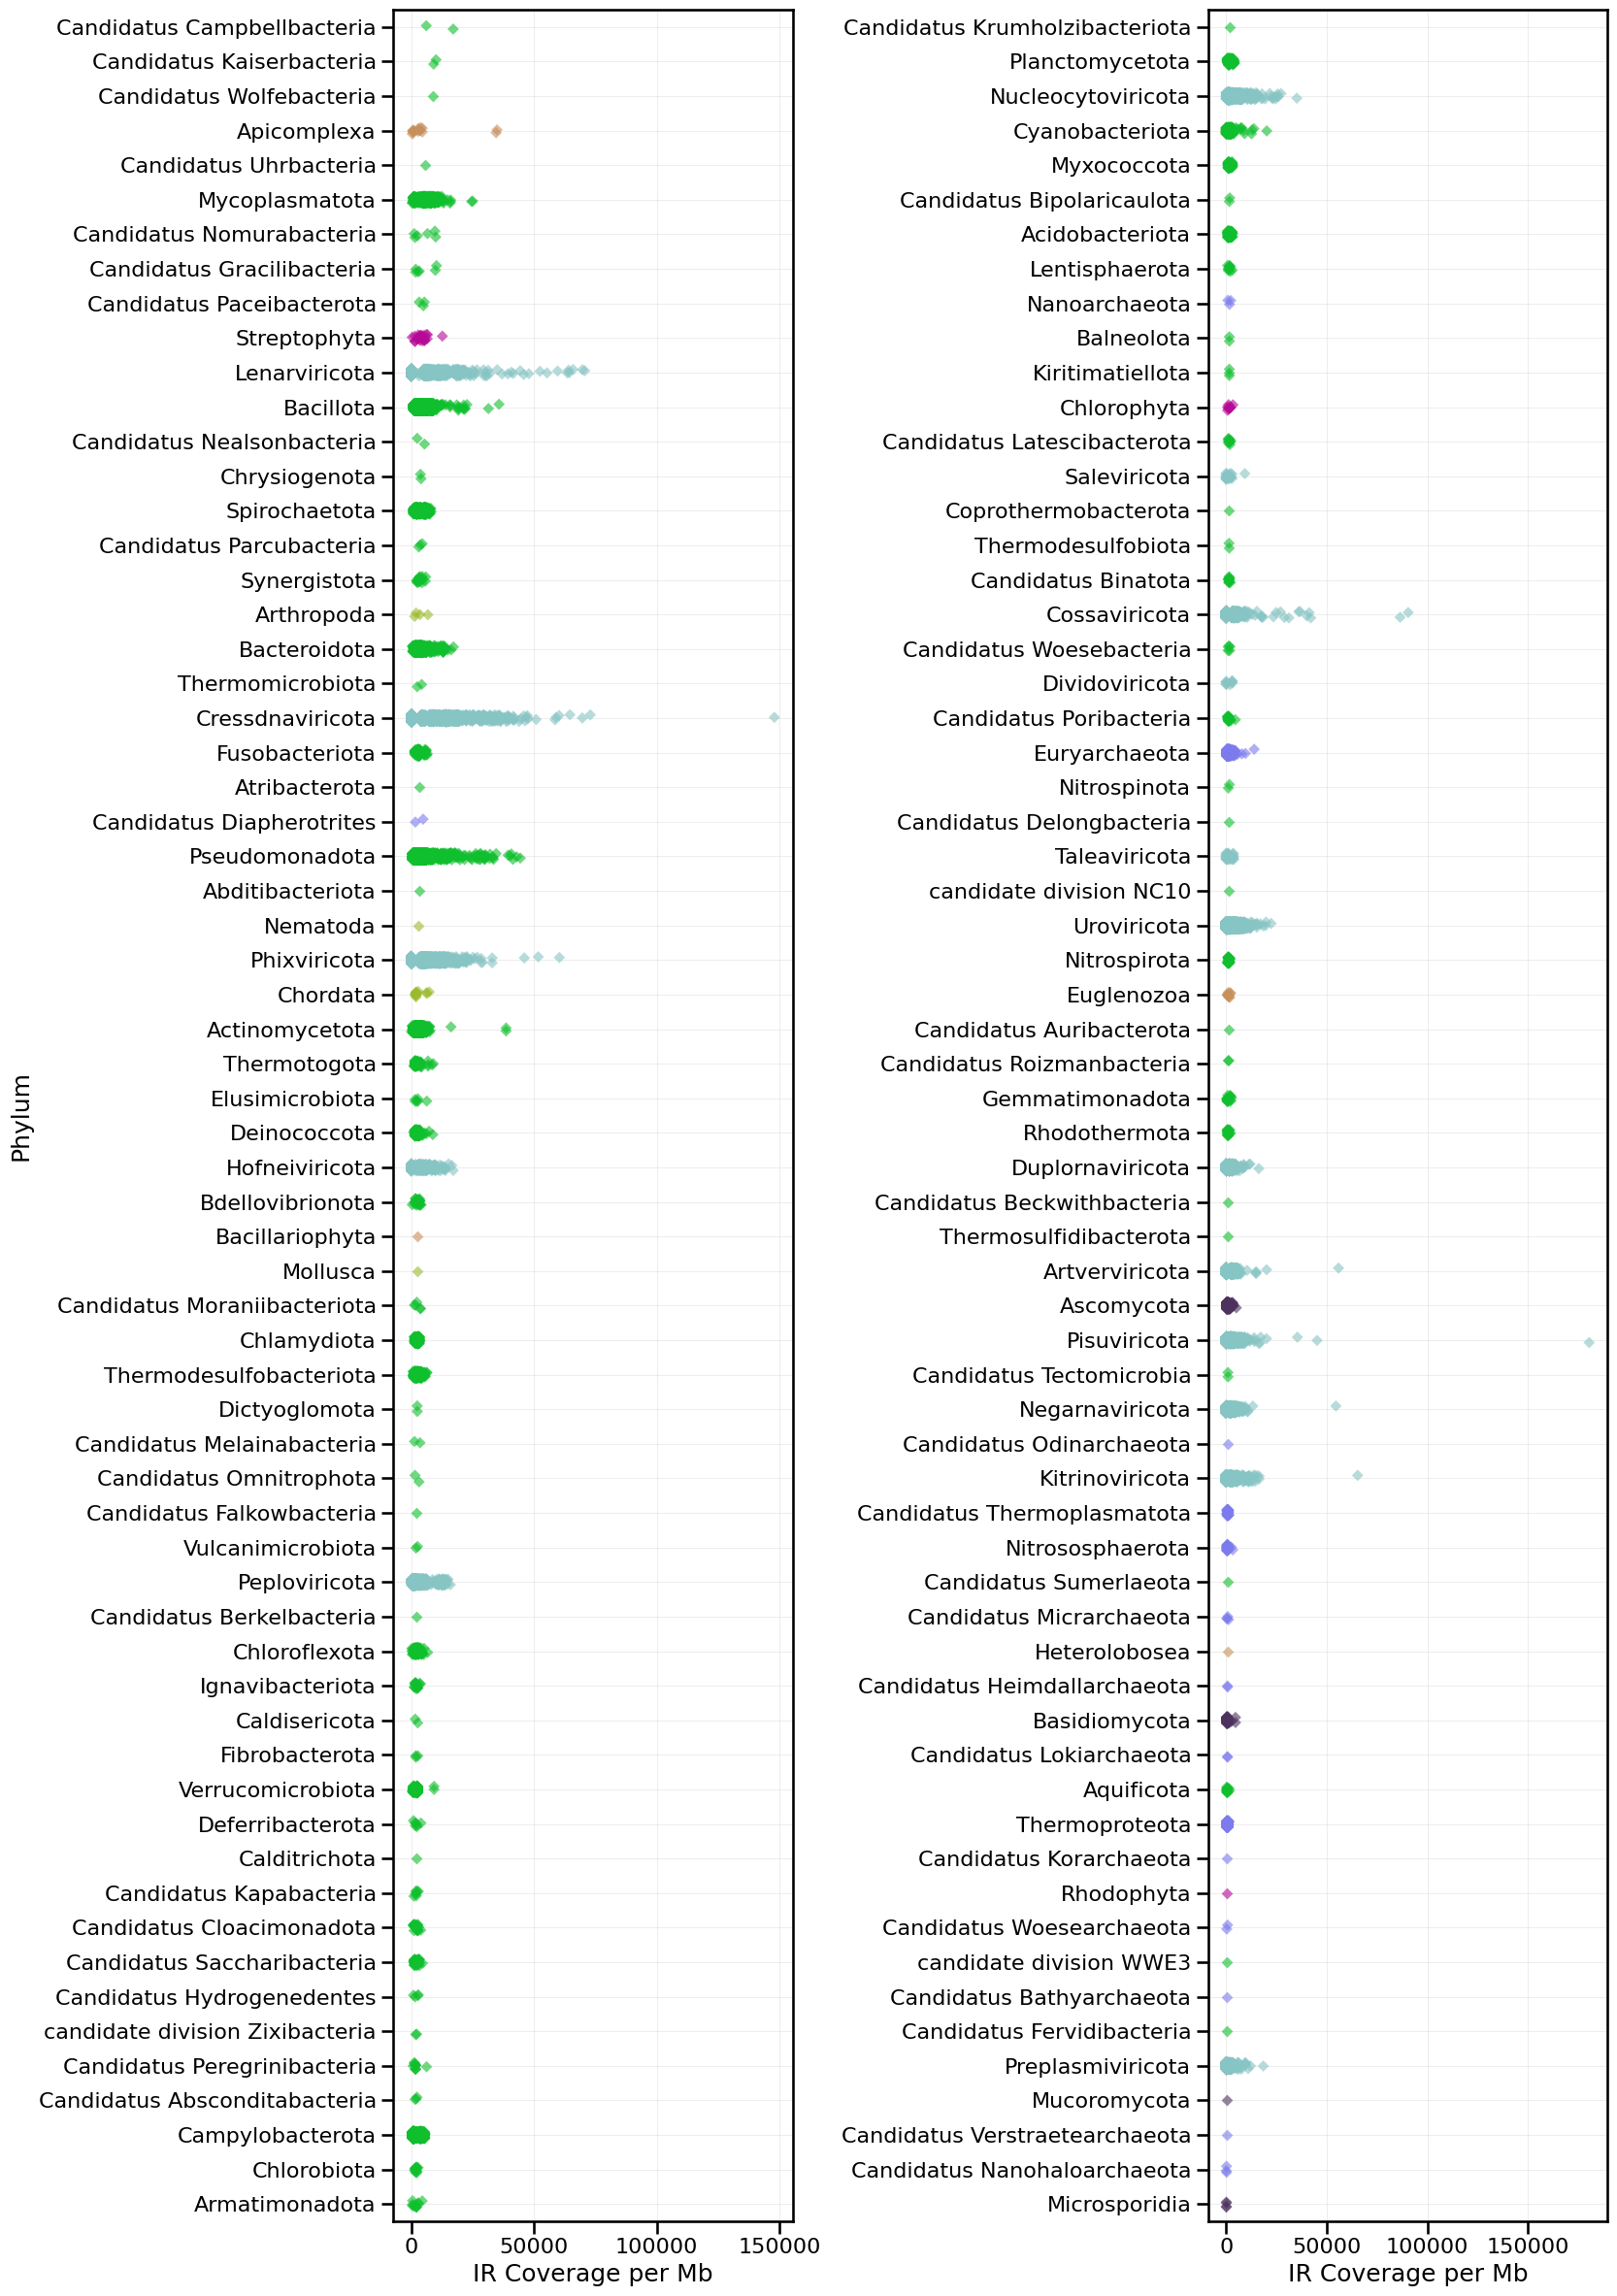

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 24))
sns.stripplot(data=top_grouped_phylum,
                    y="phylum",
                    x="coverage",
                    hue="kingdom",
                      jitter=True, 
                      s=6,
                  marker='D',
                    palette=kingdom_color_palette,
                    # width=0.7,
                    #showfliers=False,
                dodge=0.0,
                  alpha=0.6,
            ax=ax[0],
            zorder=3,
           )
sns.stripplot(data=bottom_grouped_phylum,
                    y="phylum",
                    x="coverage",
                    hue="kingdom",
                      jitter=True, 
                      s=6,
                      marker='D',
                    palette=kingdom_color_palette,
                    # width=0.6,
                    # showfliers=False,
                  alpha=0.6,
                dodge=0.0,
            ax=ax[1],
            zorder=3,
           )

for i in range(2):
    ax[i].xaxis.grid(True, linewidth=0.2, alpha=0.2, zorder=0)
    if i == 0:
        ax[i].set_ylabel("Phylum")
        ax[i].yaxis.label.set_size(18)
    else:
        ax[i].set_ylabel("")
        # ax[i].legend(handles=[mpatches.Patch(color=color, label=kingdom.capitalize()) for kingdom, color in kingdom_color_palette.items()],
        #                    bbox_to_anchor=(0.95, 0.2), frameon=True, 
        #                     fancybox=True, 
        #                     shadow=False, 
        #                     title="Kingdom", 
        #                     title_fontsize='medium', 
        #                     prop={"size": 7})
    ax[i].grid(lw=0.4, alpha=0.4, zorder=0)
    ax[i].legend(handles=[], frameon=False)

    ax[i].set_xlabel("IR Coverage per Mb")
    ax[i].xaxis.label.set_size(18)
    ax[i].tick_params(axis="both", which="major", labelsize=16)
plt.tight_layout()
fig.savefig(f"{DATABASE}/stripplot_phylum_coverage.png", bbox_inches='tight')

In [98]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'